### Further clean DELINQUENCY variables (round to 2 decimals / integerize / ...)

In [1]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from pandarallel import pandarallel
from tqdm import tqdm

In [2]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [3]:
from utils.common import *
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, print_percentile,
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series, describe_all, check_psi, plot_heatmap, check_summary
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, check_roc_auc,
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import *

In [4]:
%load_ext autoreload
%autoreload

In [5]:
gc.collect()

36

In [6]:
START = time.time()

### Setup

In [7]:
%%time
train = read_file(f"../{RAW_TRAIN_PARQUET_PATH}/delinquency1.parquet")
test = read_file(f"../{RAW_TEST_PARQUET_PATH}/delinquency1.parquet")

Shape of data: (5531451, 54)
Shape of data: (11363762, 54)
CPU times: user 7.69 s, sys: 11.9 s, total: 19.5 s
Wall time: 13.5 s


In [8]:
%%time
labels = pd.read_csv(f"../{RAW_DATA_PATH}/train_labels.csv")
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 982 ms, sys: 948 ms, total: 1.93 s
Wall time: 3.17 s


In [9]:
%%time
public_test, private_test = split_public_private(test)

Public size: 5719469, Private size: 5644293
CPU times: user 3.24 s, sys: 2.41 s, total: 5.65 s
Wall time: 8.29 s


In [10]:
del test

In [11]:
train.shape, public_test.shape, private_test.shape

((5531451, 55), (5719469, 54), (5644293, 54))

In [12]:
df_list = [train, public_test, private_test]

In [13]:
print(sorted(get_cols(train, ["D_"])))

['D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_66', 'D_68', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96']


In [14]:
train["target"].mean()

0.24909720794778803

In [15]:
for df in df_list:
    insert_row_number(df)

Done insertion
Done insertion
Done insertion


In [16]:
pandarallel.initialize(nb_workers=12, progress_bar=False, use_memory_fs=False)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [17]:
# train_corr = train.loc[:, train.columns[4:-1]].corr()
# train_corr.to_csv(f"../{RAW_DATA_PATH}/pre_clean_train_delinquency1_corr.csv", index=False)

In [18]:
# train_corr = read_file(f"../{RAW_DATA_PATH}/pre_clean_train_delinquency1_corr.csv")
# train_corr.index = train_corr.columns

### D_39 (KIV) Suspicious Spike

In [19]:
# plot_target_check(train, "D_39", q=50, use_raw_bin=True, nunique_thr=1000)

In [20]:
%%time
df_list = round_dfs(df_list, col="D_39", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0589
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0370
CPU times: user 2.41 s, sys: 1.75 s, total: 4.16 s
Wall time: 5.09 s


In [21]:
# plot_target_check(train, "D_39", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

In [22]:
%%time
for df in df_list:
    df["D_39"] = ((df["D_39"] - 0.02) / 0.0291).apply(np.floor).replace(-1, np.nan)

CPU times: user 108 ms, sys: 63.4 ms, total: 172 ms
Wall time: 171 ms


In [23]:
print_percentile(df_list, "D_39", 99.3)

99.3th percentile:
train : 61.0
public test : 60.0
private test : 60.0


In [24]:
for df in df_list:
    df = clip_col(df, "D_39", top_value=60, add_new_col=False)

3053463 null count, 0.552 null proportion
0.1787 of the targets have label = 1


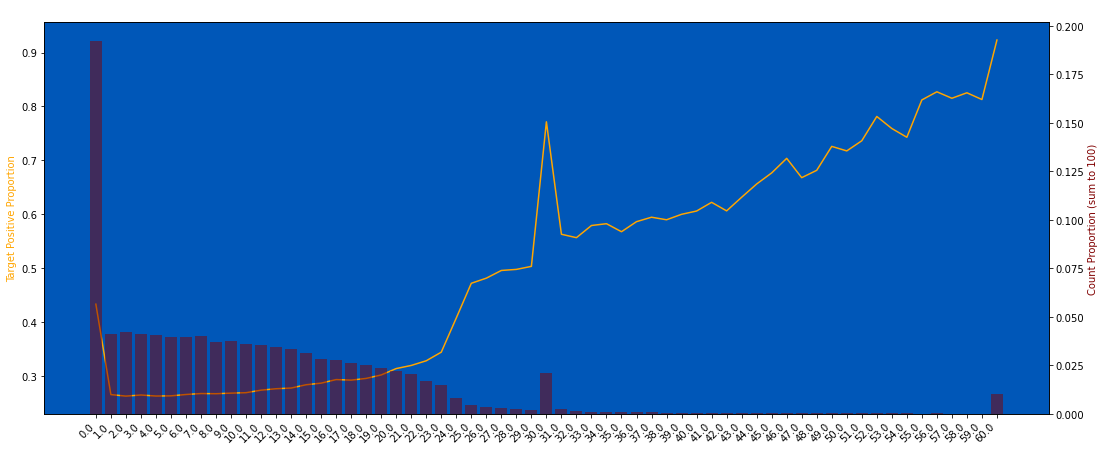

In [25]:
plot_target_check(train, "D_39", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [26]:
# describe_all(df_list, "D_39").loc["null_proportion"]

In [27]:
# plot_train_test_distribution(df_list, "D_39", nunique_thr=1000)

### D_41 (Done)

In [28]:
# plot_target_check(train, "D_41", q=50, use_raw_bin=True)

In [29]:
%%time
df_list = round_dfs(df_list, col="D_41", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0816
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0750
CPU times: user 2.2 s, sys: 1.3 s, total: 3.51 s
Wall time: 4.41 s


In [30]:
# %%time
# for df in df_list:
#     df["D_41_"] = df["D_41"].parallel_apply(lambda x: manual_stack(x, start=0.04, stack_interval=0.05, denom=100))

In [31]:
print_percentile(df_list, "D_41", 99.01)

99.01th percentile:
train : 1.0
public test : 1.0
private test : 1.0


In [32]:
for df in df_list:
    df = clip_col(df, "D_41", top_value=2, add_new_col=False)

In [33]:
for df in df_list:
    df["D_41"] = df["D_41"].replace(0, np.nan)

4813316 null count, 0.870 null proportion
0.2086 of the targets have label = 1


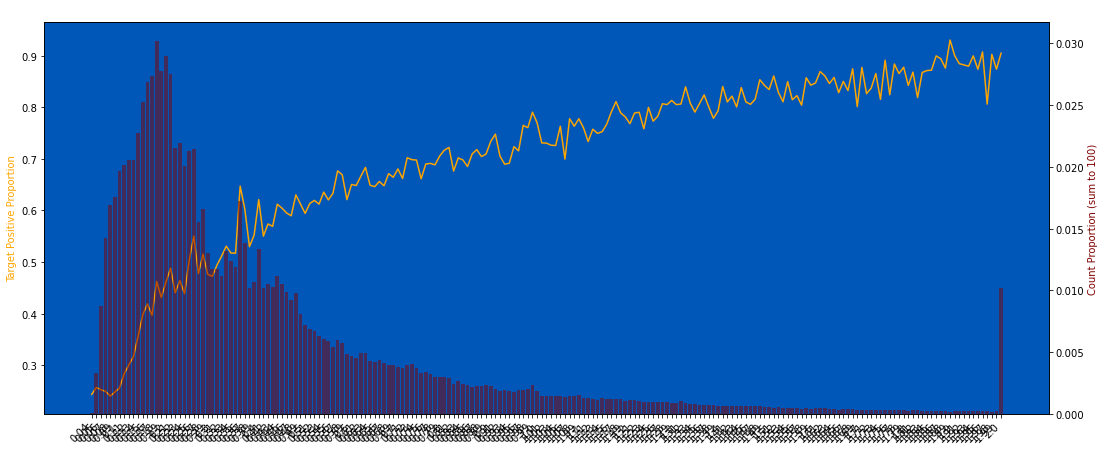

In [34]:
plot_target_check(train, "D_41", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [35]:
# describe_all(df_list, "D_41").loc["null_proportion"]

In [36]:
# plot_train_test_distribution(df_list, "D_41", nunique_thr=1000)

### D_42 (KIV) can try impute?

In [37]:
# plot_target_check(train, "D_42", q=50, use_raw_bin=True)

In [38]:
%%time
df_list = round_dfs(df_list, col="D_42", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1110
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0645
CPU times: user 1.34 s, sys: 1.76 s, total: 3.1 s
Wall time: 4.54 s


In [39]:
print_percentile(df_list, "D_42", 99.4)

99.4th percentile:
train : 1.18
public test : 1.44
private test : 1.64


In [40]:
for df in df_list:
    df = clip_col(df, "D_42", top_value=1.2, add_new_col=False)

4740137 null count, 0.857 null proportion
0.2075 of the targets have label = 1


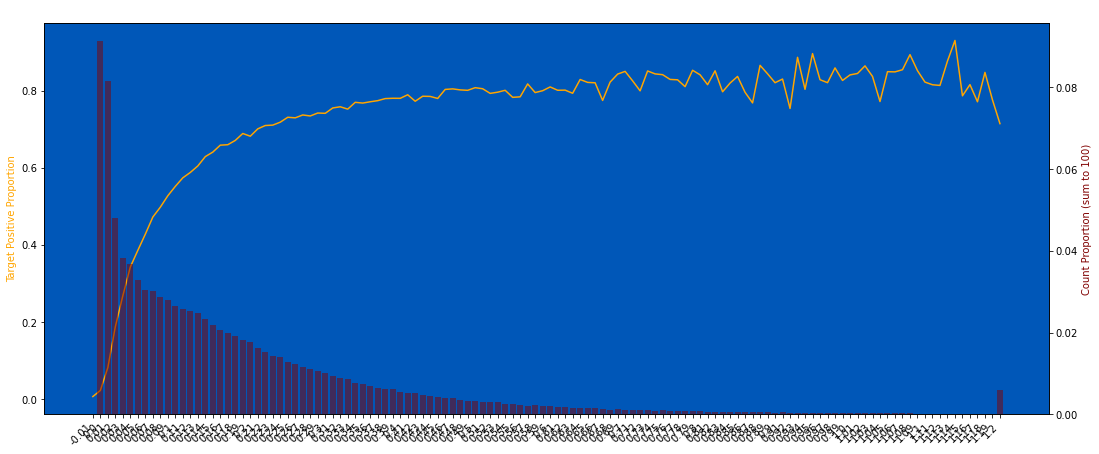

In [41]:
plot_target_check(train, "D_42", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [42]:
# plot_train_test_distribution(df_list, "D_42", nunique_thr=1000)

In [43]:
# describe_all(df_list, "D_42").loc["null_proportion"]

### D_43 (Done)

In [44]:
# plot_target_check(train, "D_43", q=50, use_raw_bin=True)

In [45]:
%%time
df_list = round_dfs(df_list, col="D_43", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0965
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0962
CPU times: user 2.11 s, sys: 1.65 s, total: 3.76 s
Wall time: 4.74 s


In [46]:
print_percentile(df_list, "D_43", 99.9)

99.9th percentile:
train : 2.12
public test : 2.1
private test : 1.92


In [47]:
for df in df_list:
    df = clip_col(df, "D_43", top_value=2, add_new_col=False)

1658396 null count, 0.300 null proportion
0.1673 of the targets have label = 1


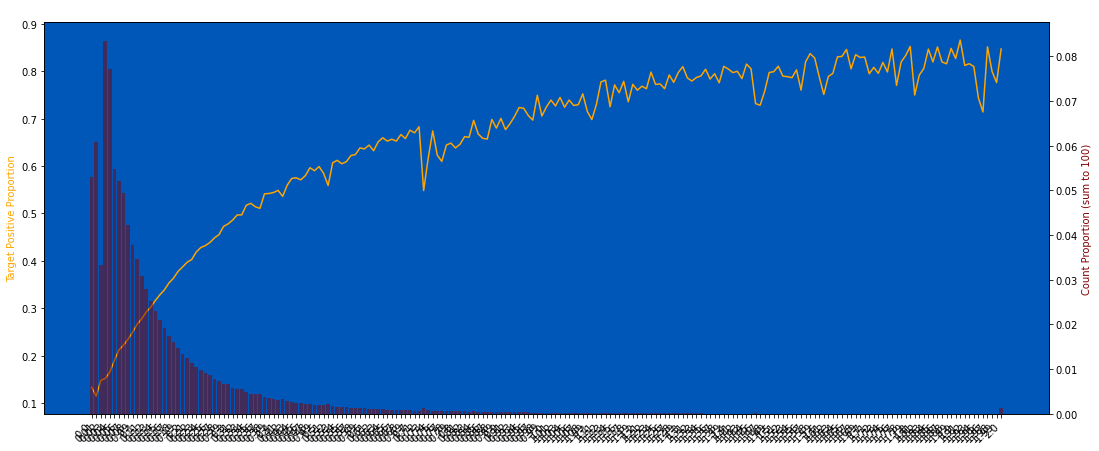

In [48]:
plot_target_check(train, "D_43", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [49]:
# plot_train_test_distribution(df_list, "D_43", nunique_thr=1000)

In [50]:
# describe_all(df_list, "D_43").loc["null_proportion"]

### D_44 (Done)

In [51]:
# plot_target_check(train, "D_44", q=50, use_raw_bin=True, nunique_thr=1000)

In [52]:
%%time
df_list = round_dfs(df_list, col="D_44", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0117
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0079
CPU times: user 2.19 s, sys: 1.57 s, total: 3.76 s
Wall time: 4.68 s


In [53]:
print_percentile(df_list, "D_44", 99.99)

99.99th percentile:
train : 2.38
public test : 2.5
private test : 2.5


In [54]:
%%time
for df in df_list:
    df["D_44"] = (df["D_44"] * 8).round(0)

CPU times: user 20.3 ms, sys: 35.3 ms, total: 55.7 ms
Wall time: 54.5 ms


In [55]:
print_percentile(df_list, "D_44", 99.8)

99.8th percentile:
train : 12.0
public test : 12.0
private test : 12.0


In [56]:
for df in df_list:
    df = clip_col(df, "D_44", top_value=12, add_new_col=False)

274319 null count, 0.050 null proportion
0.2406 of the targets have label = 1


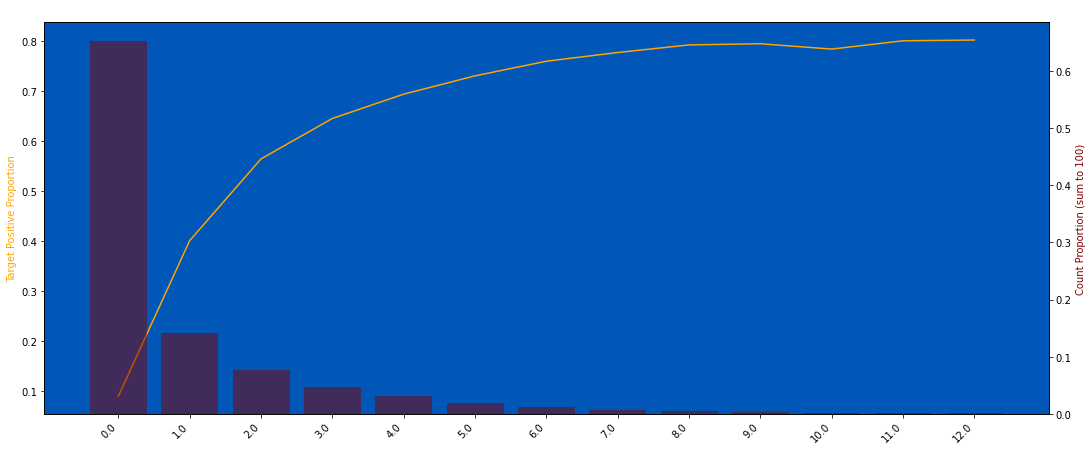

In [57]:
plot_target_check(train, "D_44", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [58]:
# plot_train_test_distribution(df_list, "D_44", nunique_thr=1000, without_drop_tail=True)

In [59]:
# describe_all(df_list, "D_44").loc["null_proportion"]

### D_45 (KIV) Should we drop this?

In [60]:
# plot_target_check(train, "D_45", q=50, use_raw_bin=True)

In [61]:
%%time
df_list = round_dfs(df_list, col="D_45", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1170
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1131
CPU times: user 3.11 s, sys: 1.68 s, total: 4.78 s
Wall time: 4.75 s


In [62]:
print_percentile(df_list, "D_45", 99.99)

99.99th percentile:
train : 1.51
public test : 1.52
private test : 1.5


In [63]:
for df in df_list:
    df = clip_col(df, "D_45", top_value=1.5, add_new_col=False)

2017 null count, 0.000 null proportion
0.3560 of the targets have label = 1


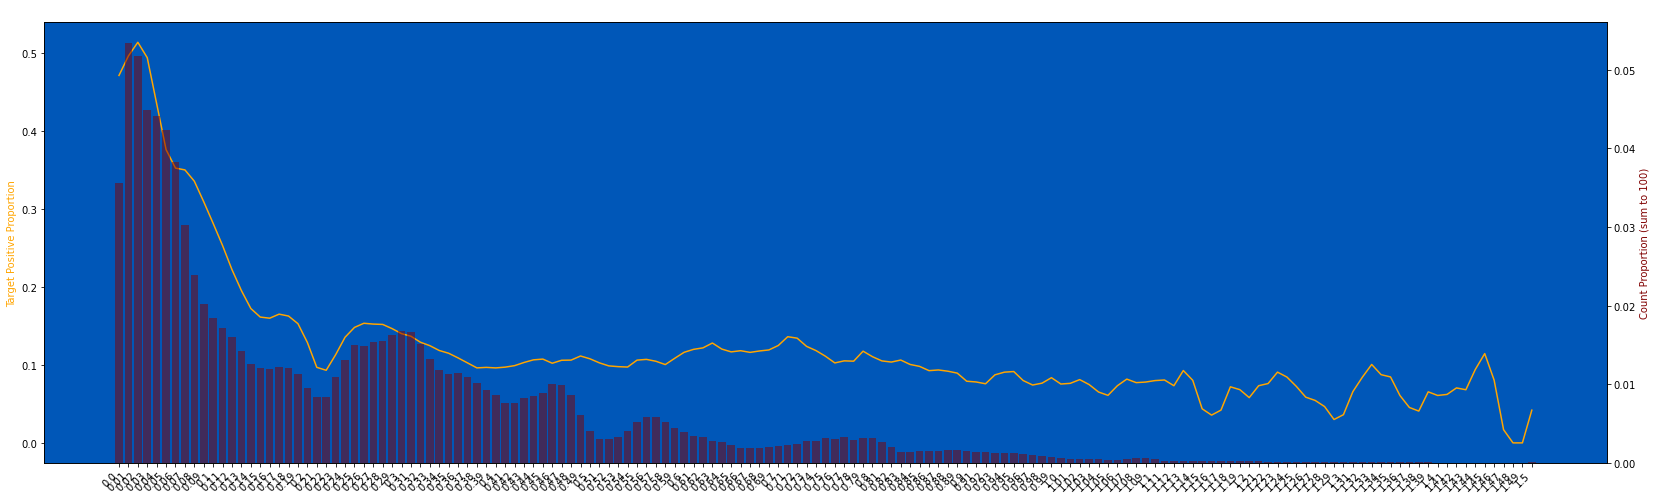

In [64]:
plot_target_check(train, "D_45", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True, figsize=(28, 9))

Train-Public PSI: 0.0748, Train-Private PSI: 0.1131


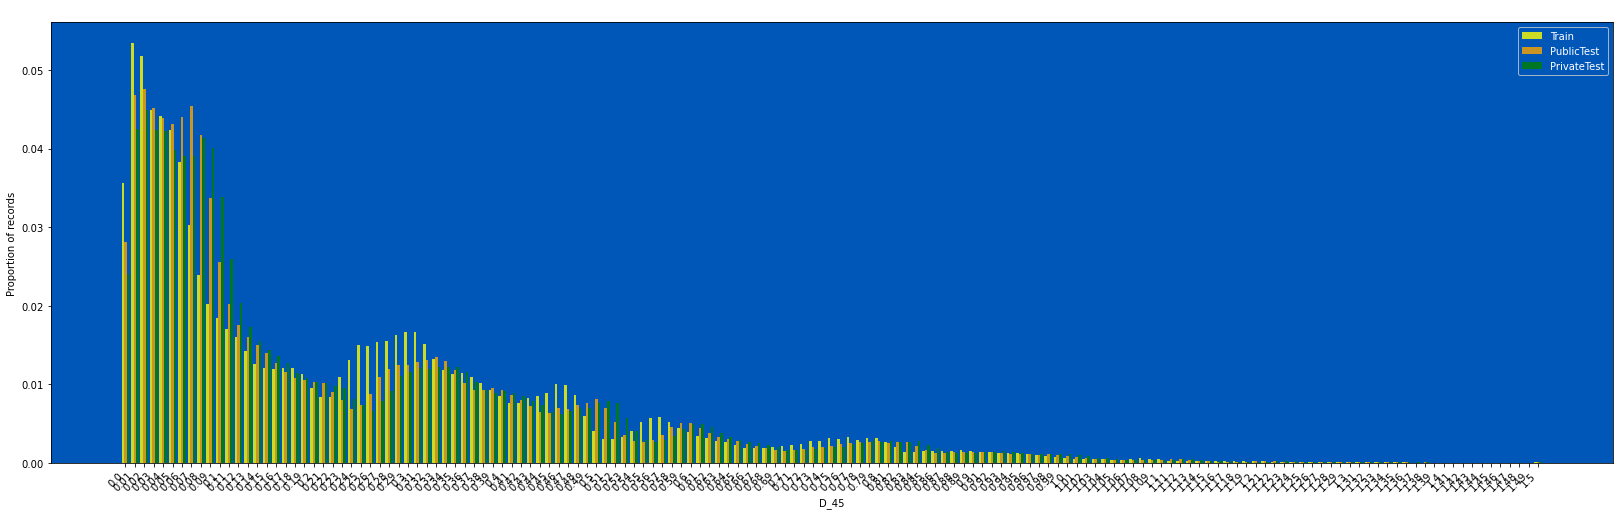

In [65]:
plot_train_test_distribution(df_list, "D_45", nunique_thr=8000, without_drop_tail=True, figsize=(28, 9))

In [66]:
describe_all(df_list, "D_45").loc["null_proportion"]

train          0.0004
public test    0.0003
private test   0.0002
Name: null_proportion, dtype: float64

### D_46 (KIV) Similar pattern with P_3, can try to feature cross them.

In [67]:
# plot_target_check(train, "D_46", q=50, use_raw_bin=True)

In [68]:
%%time
df_list = round_dfs(df_list, col="D_46", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0650
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0618
CPU times: user 2.28 s, sys: 1.61 s, total: 3.89 s
Wall time: 4.84 s


In [69]:
print_percentile(df_list, "D_46", 0.1)

0.1th percentile:
train : -0.65
public test : -0.69
private test : -0.71


In [70]:
for df in df_list:
    df = clip_col(df, "D_46", top_value=1.25, add_new_col=False)
    df = clip_col(df, "D_46", btm_value=-0.7, add_new_col=False)

1211699 null count, 0.219 null proportion
0.1940 of the targets have label = 1


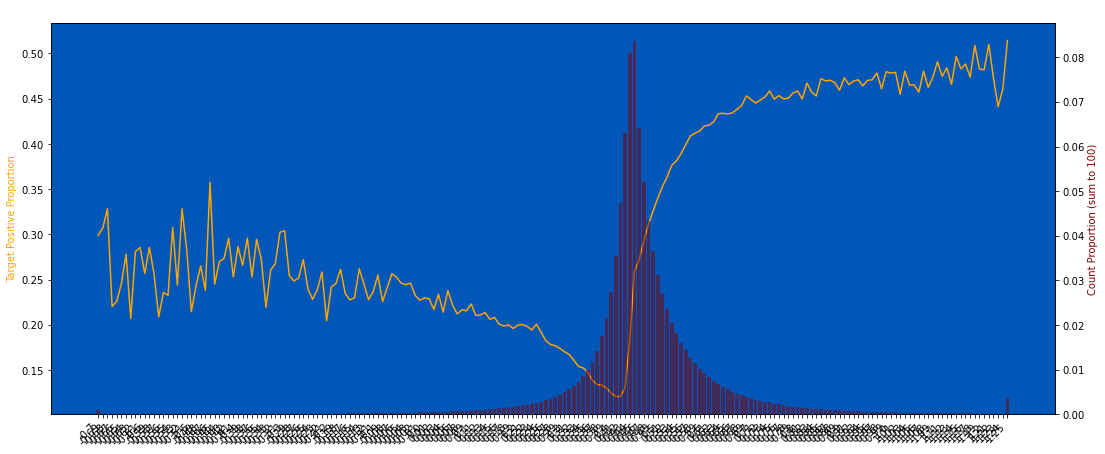

In [71]:
d46_summary = plot_target_check(train, "D_46", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, return_df=True)

In [72]:
# plot_train_test_distribution(df_list, "D_46", nunique_thr=8000)

In [73]:
# describe_all(df_list, "D_46").loc["null_proportion"]

### D_47 (Done)

In [74]:
# plot_target_check(train, "D_47", q=50, use_raw_bin=True)

In [75]:
%%time
df_list = round_dfs(df_list, col="D_47", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0537
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0276
CPU times: user 2.15 s, sys: 1.61 s, total: 3.76 s
Wall time: 4.68 s


In [76]:
describe_all(df_list, "D_47")

,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.4021,0.3912,0.3913
std,0.2348,0.2328,0.2326
min,-0.0300,-0.0300,-0.0300
25%,0.2300,0.2200,0.2200
50%,0.3800,0.3600,0.3600
75%,0.5600,0.5400,0.5400
max,1.6400,1.4800,1.5100
null_proportion,0.0000,0.0000,0.0000


In [77]:
print_percentile(df_list, "D_47", 99.975)

99.975th percentile:
train : 1.25
public test : 1.24
private test : 1.24


In [78]:
for df in df_list:
    df = clip_col(df, "D_47", top_value=1.24, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


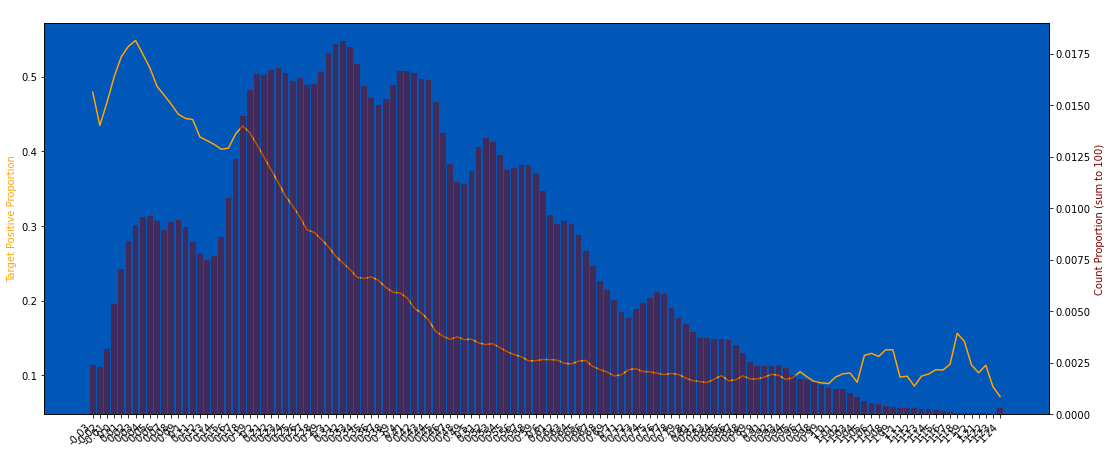

In [79]:
plot_target_check(train, "D_47", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0144, Train-Private PSI: 0.0232


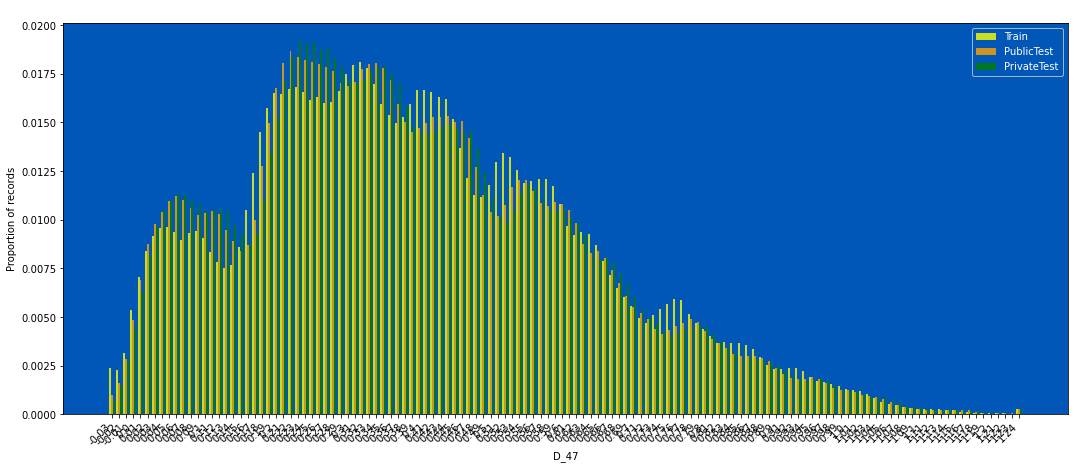

In [80]:
plot_train_test_distribution(df_list, "D_47", nunique_thr=8000, without_drop_tail=True)

### D_48 (Done)

In [81]:
# plot_target_check(train, "D_48", q=50, use_raw_bin=True)

In [82]:
%%time
df_list = round_dfs(df_list, col="D_48", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0693
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0656
CPU times: user 2.38 s, sys: 1.61 s, total: 3.99 s
Wall time: 4.95 s


In [83]:
describe_all(df_list, "D_48")

,train,public test,private test
count,"4,812,726.0000","4,997,589.0000","4,919,037.0000"
mean,0.3766,0.3762,0.3666
std,0.3265,0.3285,0.3263
min,-0.0100,-0.0100,-0.0100
25%,0.0800,0.0800,0.0700
50%,0.2800,0.2800,0.2600
75%,0.6600,0.6700,0.6500
max,8.9700,7.5400,6.7900
null_proportion,0.1299,0.1262,0.1285


In [84]:
print_percentile(df_list, "D_48", 99.95)

99.95th percentile:
train : 1.39
public test : 1.41
private test : 1.36


In [85]:
for df in df_list:
    df = clip_col(df, "D_48", top_value=1.4, add_new_col=False)

718725 null count, 0.130 null proportion
0.1221 of the targets have label = 1


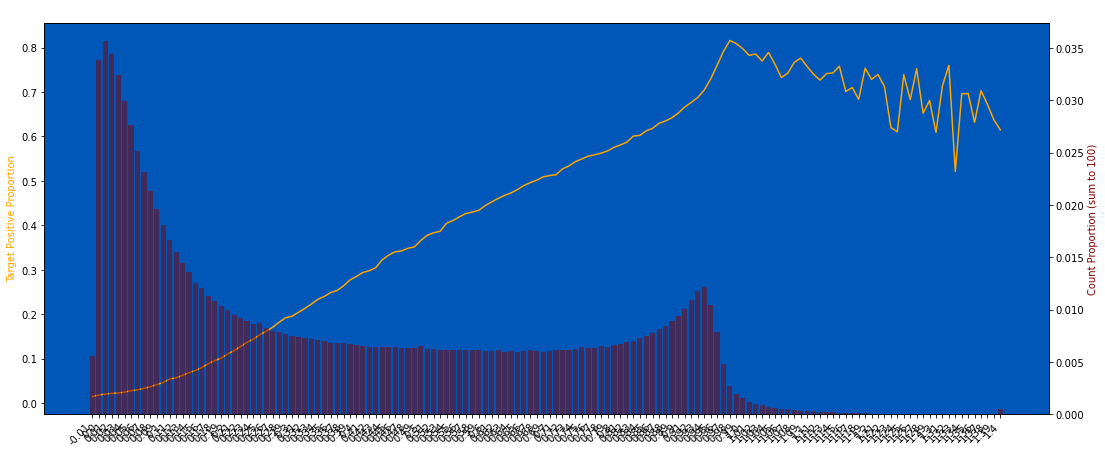

In [86]:
plot_target_check(train, "D_48", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0006, Train-Private PSI: 0.0020


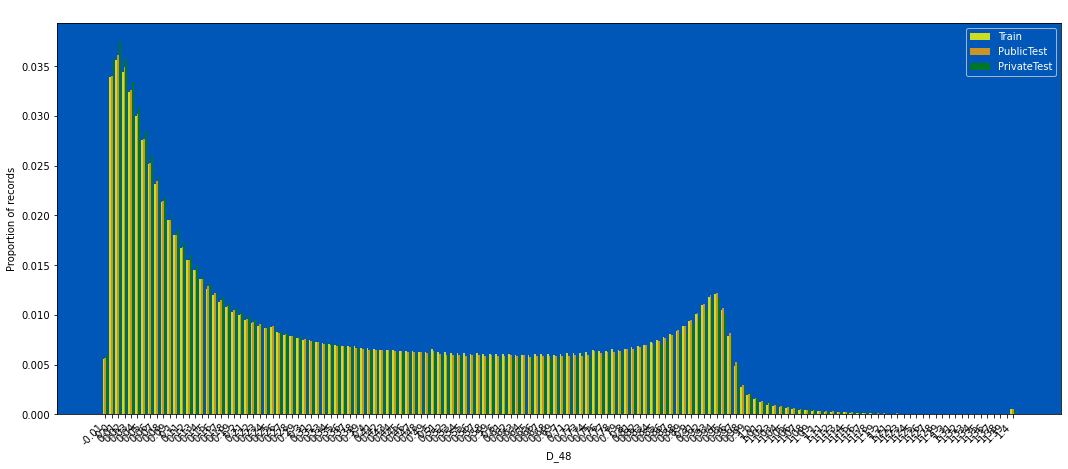

In [87]:
plot_train_test_distribution(df_list, "D_48", nunique_thr=8000, without_drop_tail=True)

In [88]:
describe_all(df_list, "D_48").loc["null_proportion"]

train          0.1299
public test    0.1262
private test   0.1285
Name: null_proportion, dtype: float64

### D_49 (Done)

In [89]:
# plot_target_check(train, "D_49", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [90]:
%%time
df_list = round_dfs(df_list, col="D_49", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0423
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0430
CPU times: user 1.21 s, sys: 1.56 s, total: 2.78 s
Wall time: 3.86 s


In [91]:
print_percentile(df_list, "D_49", 99.5)

99.5th percentile:
train : 1.24
public test : 1.28
private test : 1.27


In [92]:
for df in df_list:
    df = clip_col(df, "D_49", top_value=1.5, add_new_col=False)

In [93]:
for df in tqdm(df_list): 
    df["D_49"] = df["D_49"].parallel_apply(lambda x: manual_stack(x, start=0, stack_interval=0.03, denom=100))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.45it/s]


4985917 null count, 0.901 null proportion
0.2162 of the targets have label = 1


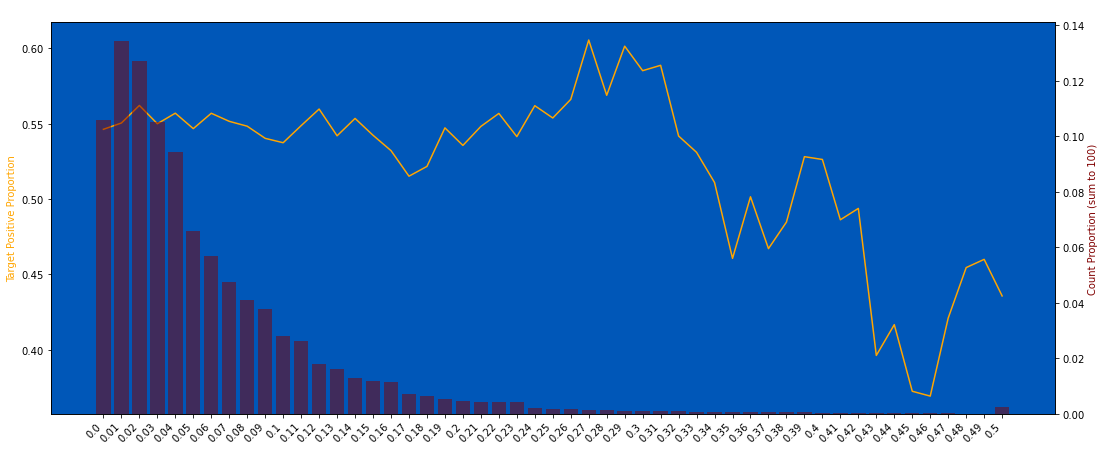

In [94]:
plot_target_check(train, "D_49", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [95]:
# plot_train_test_distribution(df_list, "D_49", nunique_thr=1000)

In [96]:
# describe_all(df_list, "D_49").loc["null_proportion"]

### D_50 (Done)

In [97]:
# plot_target_check(train, "D_50", q=50, use_raw_bin=True)

In [98]:
%%time
df_list = round_dfs(df_list, col="D_50", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0466
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0460
CPU times: user 1.62 s, sys: 1.64 s, total: 3.26 s
Wall time: 4.31 s


In [99]:
describe_all(df_list, "D_50")

,train,public test,private test
count,"2,389,049.0000","2,448,088.0000","2,432,928.0000"
mean,0.1694,0.1784,0.1833
std,0.6338,0.7785,0.7363
min,-306.4900,-207.4500,-18.4800
25%,0.0600,0.0600,0.0600
50%,0.1000,0.1100,0.1100
75%,0.1800,0.1900,0.1900
max,244.0400,354.5300,265.2700
null_proportion,0.5681,0.5720,0.5690


In [100]:
print_percentile(df_list, "D_50", 0.5)

0.5th percentile:
train : -0.01
public test : -0.01
private test : -0.01


In [101]:
for df in df_list:
    df = clip_col(df, "D_50", btm_value=-0.01, add_new_col=False)
    df = clip_col(df, "D_50", top_value=2.25, add_new_col=False)

3142402 null count, 0.568 null proportion
0.3005 of the targets have label = 1


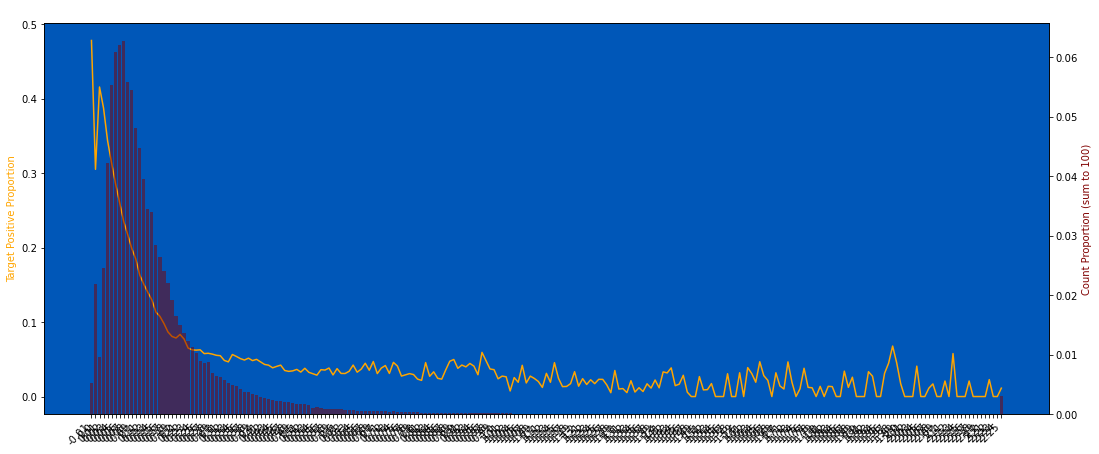

In [102]:
plot_target_check(train, "D_50", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [103]:
# plot_train_test_distribution(df_list, "D_50", nunique_thr=10000, without_drop_tail=True)

In [104]:
# describe_all(df_list, "D_50").loc["null_proportion"]

### D_51 (Done)

In [105]:
# plot_target_check(train, "D_51", q=50, use_raw_bin=True, nunique_thr=10000)

In [106]:
%%time
df_list = round_dfs(df_list, col="D_51", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0078
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0068
CPU times: user 2.17 s, sys: 1.58 s, total: 3.75 s
Wall time: 4.66 s


In [107]:
for df in df_list:
    df["D_51"] = (df["D_51"] * 3).round(0)

In [108]:
print_percentile(df_list, "D_51", 99.8)

99.8th percentile:
train : 4.0
public test : 4.0
private test : 4.0


In [109]:
for df in df_list:
    df = clip_col(df, "D_51", top_value=4, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


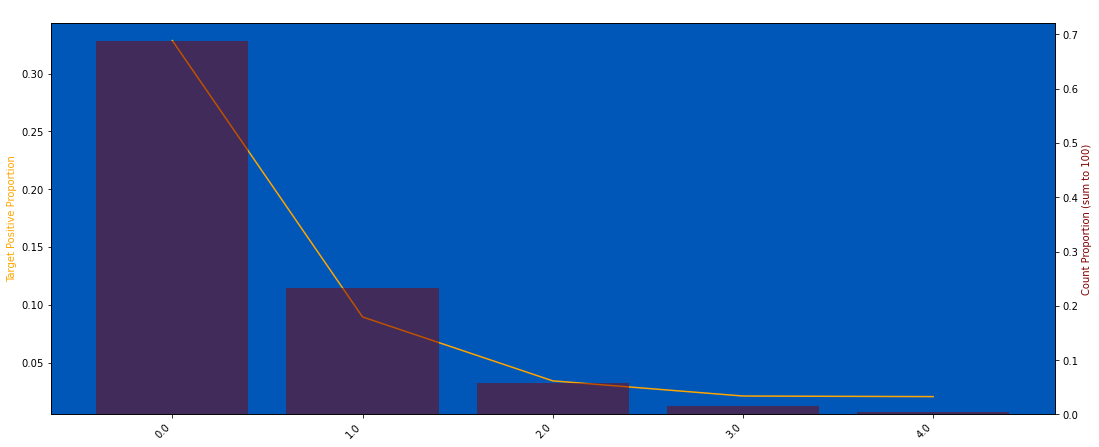

In [110]:
plot_target_check(train, "D_51", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, without_drop_tail=True)

In [111]:
# plot_train_test_distribution(df_list, "D_51", nunique_thr=1000, without_drop_tail=True)

In [112]:
# describe_all(df_list, "D_51").loc["null_proportion"]

### D_52 (KIV) Train Test Null Proportion differ

In [113]:
# plot_target_check(train, "D_52", q=50, use_raw_bin=True)

In [114]:
%%time
df_list = round_dfs(df_list, col="D_52", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0087
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0063
CPU times: user 2.37 s, sys: 2.68 s, total: 5.05 s
Wall time: 4.75 s


29563 null count, 0.005 null proportion
0.3523 of the targets have label = 1


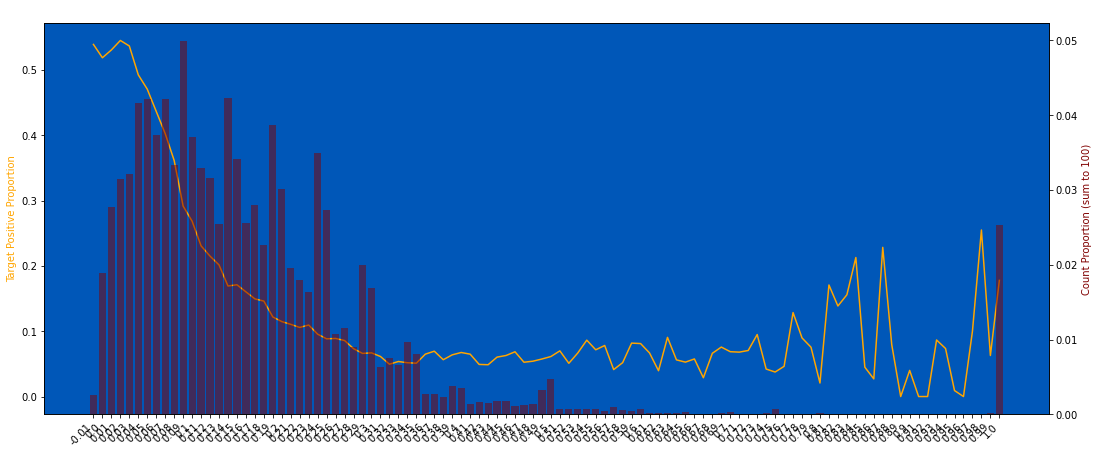

In [115]:
plot_target_check(train, "D_52", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0018, Train-Private PSI: 0.0063


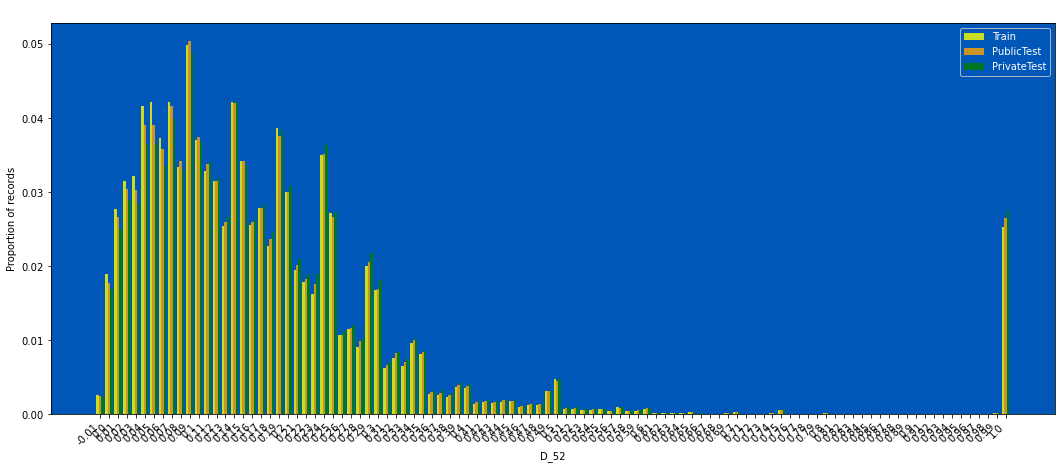

In [116]:
plot_train_test_distribution(df_list, "D_52", nunique_thr=1000, without_drop_tail=True)

In [117]:
describe_all(df_list, "D_52").loc["null_proportion"]

train          0.0053
public test    0.0029
private test   0.0025
Name: null_proportion, dtype: float64

- Null proportion is higher in training data, are some of the test data get imputed?

### D_53

In [118]:
# plot_target_check(train, "D_53", q=50, use_raw_bin=True)

In [119]:
%%time
df_list = round_dfs(df_list, col="D_53", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0794
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0624
CPU times: user 1.41 s, sys: 1.58 s, total: 2.99 s
Wall time: 4.05 s


In [120]:
describe_all(df_list, "D_53")

,train,public test,private test
count,"1,446,866.0000","1,507,100.0000","1,477,687.0000"
mean,0.0712,0.0749,0.0751
std,0.2027,0.2070,0.2036
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0100,0.0100,0.0100
75%,0.0400,0.0500,0.0500
max,7.9000,7.7200,7.2200
null_proportion,0.7384,0.7365,0.7382


In [121]:
print_percentile(df_list, "D_53", 99.9)

99.9th percentile:
train : 2.23
public test : 2.19
private test : 2.12


In [122]:
for df in df_list:
    df = clip_col(df, "D_53", top_value=2.25, add_new_col=False)

4084585 null count, 0.738 null proportion
0.1836 of the targets have label = 1


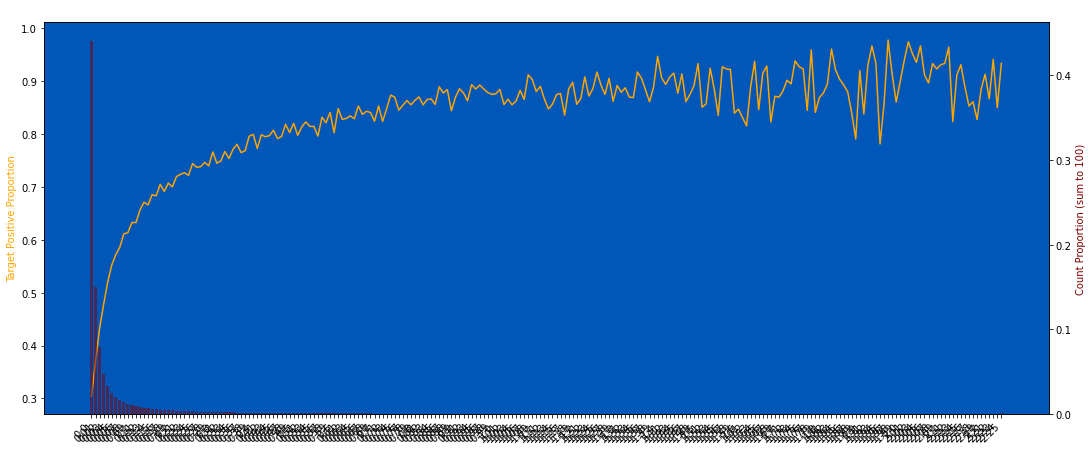

In [123]:
plot_target_check(train, "D_53", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [124]:
# plot_train_test_distribution(df_list, "D_53", nunique_thr=1000)

### D_54 (Done Binary)

In [125]:
# plot_target_check(train, "D_54", q=100, use_raw_bin=True)

In [126]:
for df in df_list:
    df["D_54"] = df["D_54"].round(0)

2016 null count, 0.000 null proportion
0.3562 of the targets have label = 1


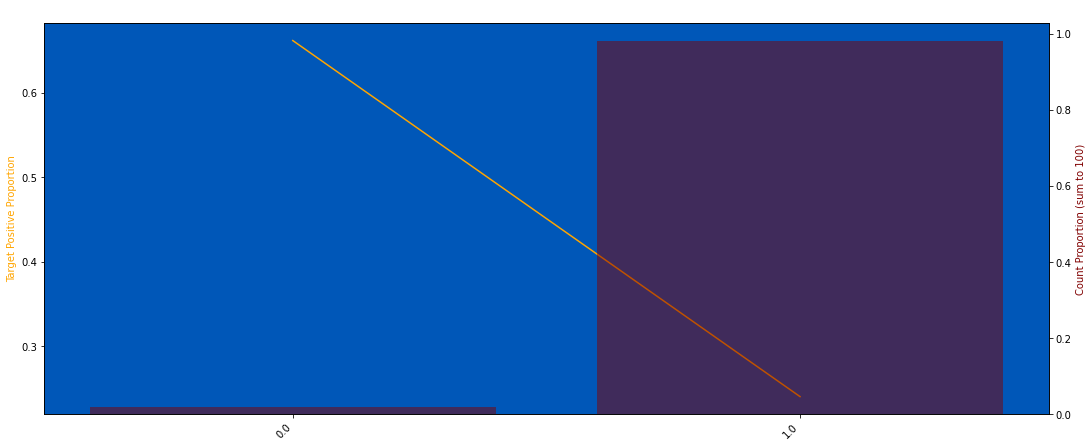

In [127]:
plot_target_check(train, "D_54", q=100, use_raw_bin=True, nunique_thr=4000, strfy_x=True, without_drop_tail=True)

In [128]:
# plot_train_test_distribution(df_list, "D_54", without_drop_tail=True)

In [129]:
# describe_all(df_list, "D_54").loc["null_proportion"]

### D_55

In [130]:
# plot_target_check(train, "D_55", q=50, use_raw_bin=True)

In [131]:
%%time
df_list = round_dfs(df_list, col="D_55", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1073
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0553
CPU times: user 2.75 s, sys: 1.48 s, total: 4.23 s
Wall time: 4.75 s


In [132]:
print_percentile(df_list, "D_55", 99.9)

99.9th percentile:
train : 1.11
public test : 1.11
private test : 1.11


In [133]:
for df in df_list:
    df = clip_col(df, "D_55", top_value=1.11, add_new_col=False)

184803 null count, 0.033 null proportion
0.1759 of the targets have label = 1


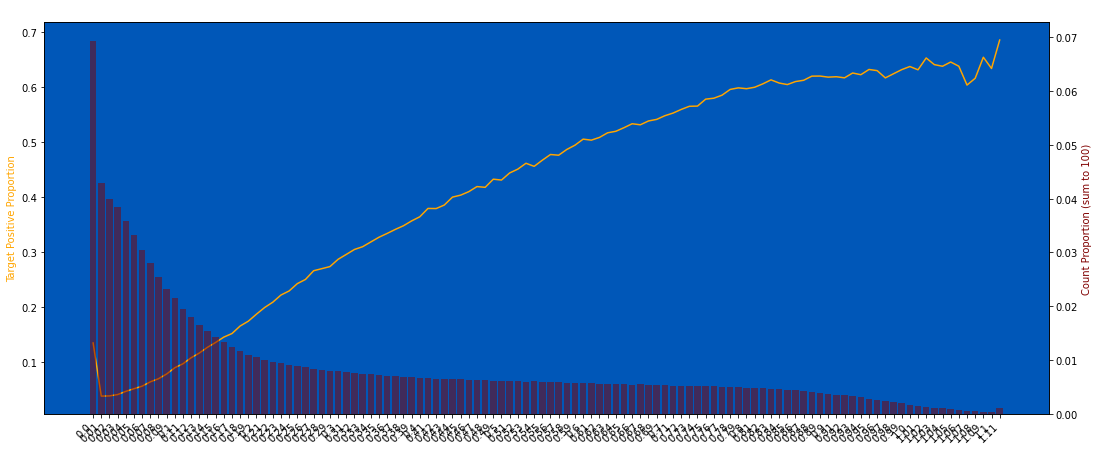

In [134]:
plot_target_check(train, "D_55", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [135]:
# plot_train_test_distribution(df_list, "D_55", nunique_thr=1000)

### D_56 (KIV) Null Proportion Differ in Train Test

In [136]:
# plot_target_check(train, "D_56", q=50, use_raw_bin=True)

In [137]:
%%time
df_list = round_dfs(df_list, col="D_56", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1125
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1115
CPU times: user 1.65 s, sys: 1.5 s, total: 3.15 s
Wall time: 4.17 s


In [138]:
print_percentile(df_list, "D_56", 99.5)

99.5th percentile:
train : 1.26
public test : 1.3
private test : 1.3


In [139]:
for df in df_list:
    df = clip_col(df, "D_56", top_value=1.3, add_new_col=False)

2990943 null count, 0.541 null proportion
0.3282 of the targets have label = 1


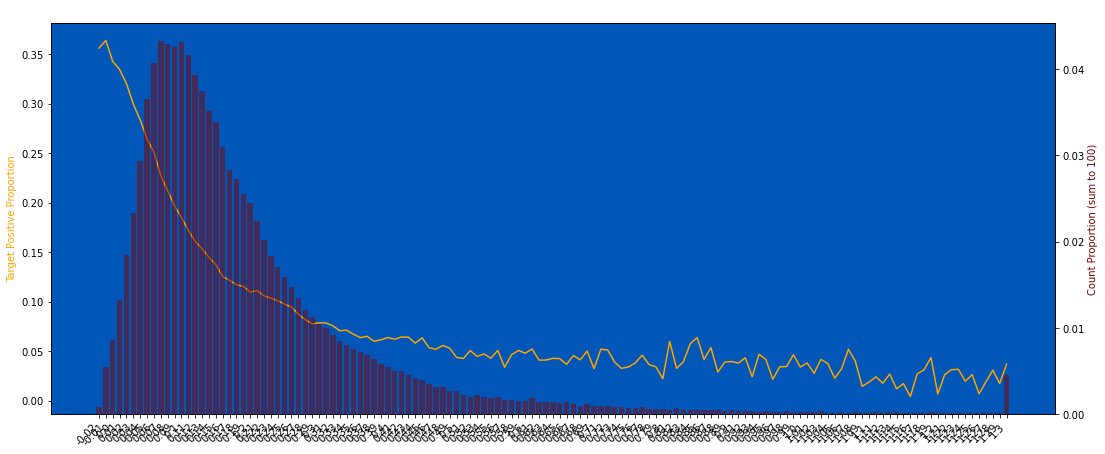

In [140]:
plot_target_check(train, "D_56", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [141]:
# plot_train_test_distribution(df_list, "D_56", nunique_thr=1000)

### D_58

In [142]:
%%time
df_list = round_dfs(df_list, col="D_58", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0013
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0010
CPU times: user 2.35 s, sys: 1.69 s, total: 4.04 s
Wall time: 4.99 s


In [143]:
for df in df_list:
    df["D_58"] = df["D_58"].replace(0, np.nan)

In [144]:
describe_all(df_list, "D_58")

,train,public test,private test
count,"3,168,715.0000","3,274,072.0000","3,167,136.0000"
mean,0.3675,0.3706,0.3679
std,0.2464,0.2472,0.2460
min,0.0100,0.0100,0.0100
25%,0.1600,0.1600,0.1600
50%,0.3200,0.3300,0.3300
75%,0.5200,0.5300,0.5200
max,1.2600,1.2600,1.2600
null_proportion,0.4271,0.4276,0.4389


2362736 null count, 0.427 null proportion
0.0654 of the targets have label = 1


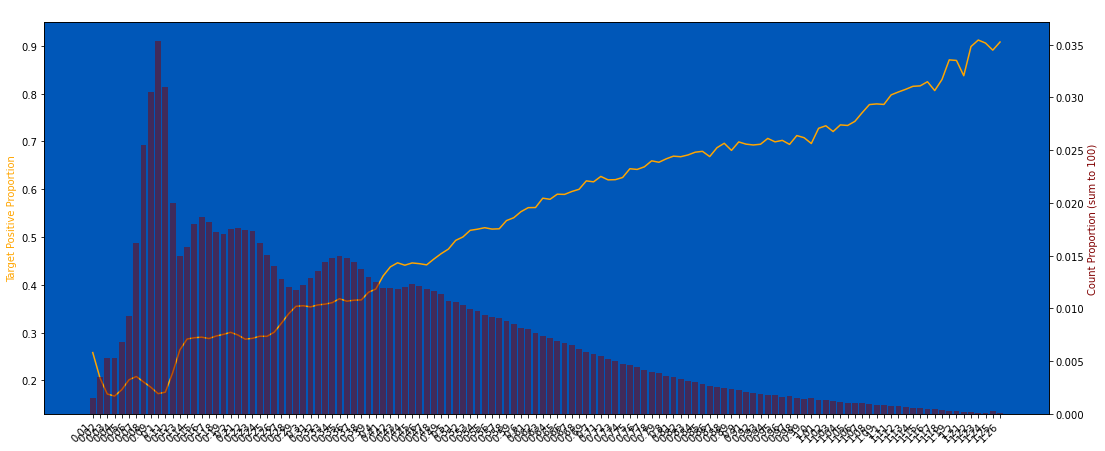

In [145]:
plot_target_check(train, "D_58", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [146]:
# plot_train_test_distribution(df_list, "D_58", nunique_thr=1000)

### D_59

In [147]:
# plot_target_check(train, "D_59", q=50, use_raw_bin=True, nunique_thr=1000)

In [148]:
%%time
df_list = round_dfs(df_list, col="D_59", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 1.7349
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 1.7208
CPU times: user 2.47 s, sys: 1.79 s, total: 4.26 s
Wall time: 5.36 s


In [149]:
print_percentile(df_list, "D_59", 99.5)

99.5th percentile:
train : 1.14
public test : 1.21
private test : 1.2


In [150]:
for df in df_list:
    df = clip_col(df, "D_59", top_value=1.2, add_new_col=False)

106725 null count, 0.019 null proportion
0.4218 of the targets have label = 1


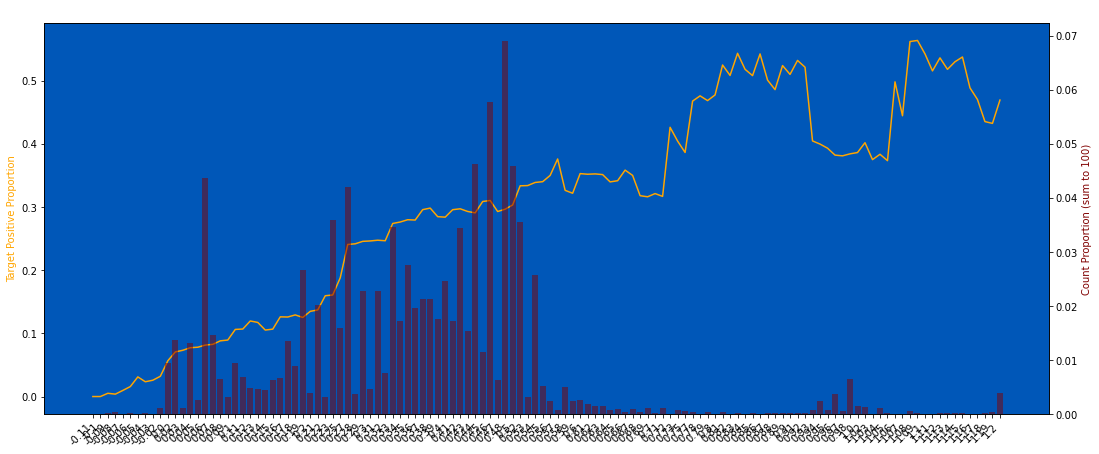

In [151]:
plot_target_check(train, "D_59", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 1.4733, Train-Private PSI: 1.6958


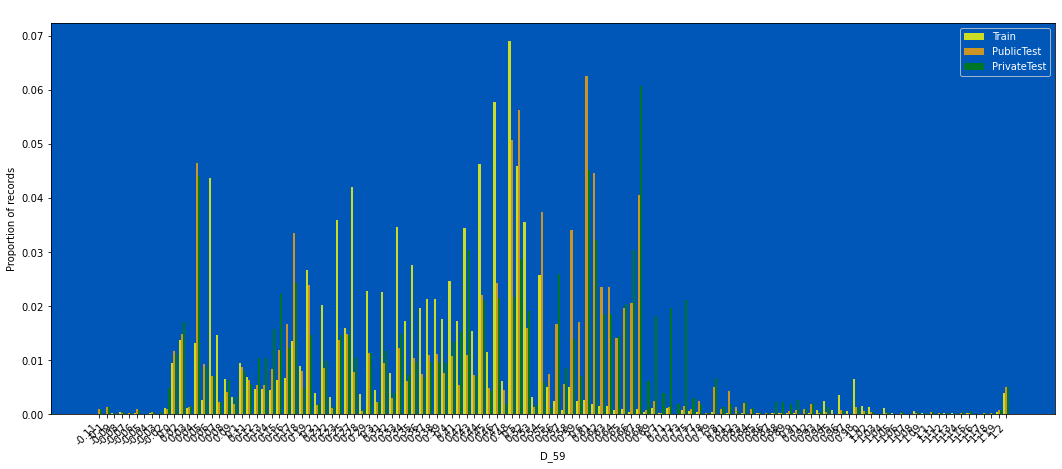

In [152]:
plot_train_test_distribution(df_list, "D_59", nunique_thr=1000, without_drop_tail=True)

In [153]:
%%time
for df in df_list:
    df = df.drop(columns="D_59", errors="ignore")

CPU times: user 1.36 s, sys: 4.93 s, total: 6.29 s
Wall time: 10.7 s


### D_60

In [154]:
# plot_target_check(train, "D_60", q=50, use_raw_bin=True)

In [155]:
%%time
df_list = round_dfs(df_list, col="D_60", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0052
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0049
CPU times: user 2.68 s, sys: 3.71 s, total: 6.39 s
Wall time: 12.8 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


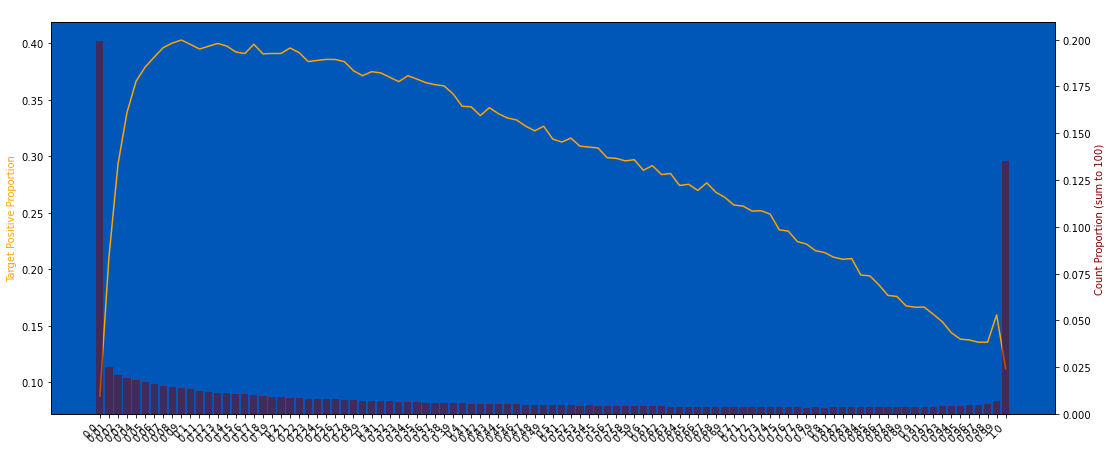

In [156]:
plot_target_check(train, "D_60", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

### D_60a (Created) for monotone

In [157]:
for df in df_list:
    df["D_60a"] = df["D_60"].replace((0, 0.01, 0.02, 0.03, 0.04, 0.05), (1.0, 0.83, 0.67, 0.5, 0.33, 0.17))

0 null count, 0.000 null proportion
nan of the targets have label = 1


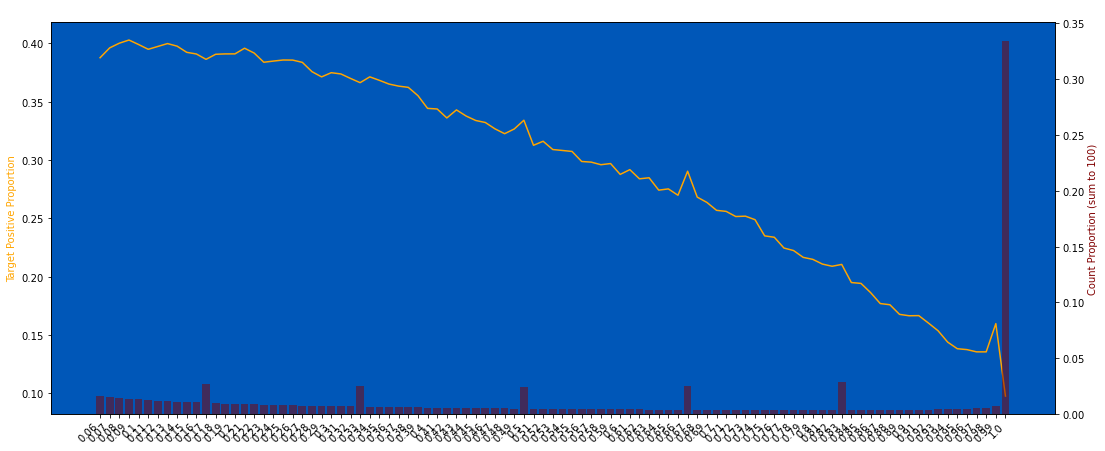

In [158]:
plot_target_check(train, "D_60a", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

In [159]:
# plot_train_test_distribution(df_list, "D_60a", nunique_thr=1000)

### D_61 (KIV) little spike

In [160]:
# plot_target_check(train, "D_61", q=50, use_raw_bin=True)

In [161]:
%%time
df_list = round_dfs(df_list, col="D_61", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0477
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0477
CPU times: user 2.63 s, sys: 2.96 s, total: 5.59 s
Wall time: 10.3 s


In [162]:
print_percentile(df_list, "D_61", 99.9)

99.9th percentile:
train : 1.38
public test : 5.29
private test : 5.68


In [163]:
for df in df_list:
    df = clip_col(df, "D_61", top_value=0.94, add_new_col=False)

598052 null count, 0.108 null proportion
0.0849 of the targets have label = 1


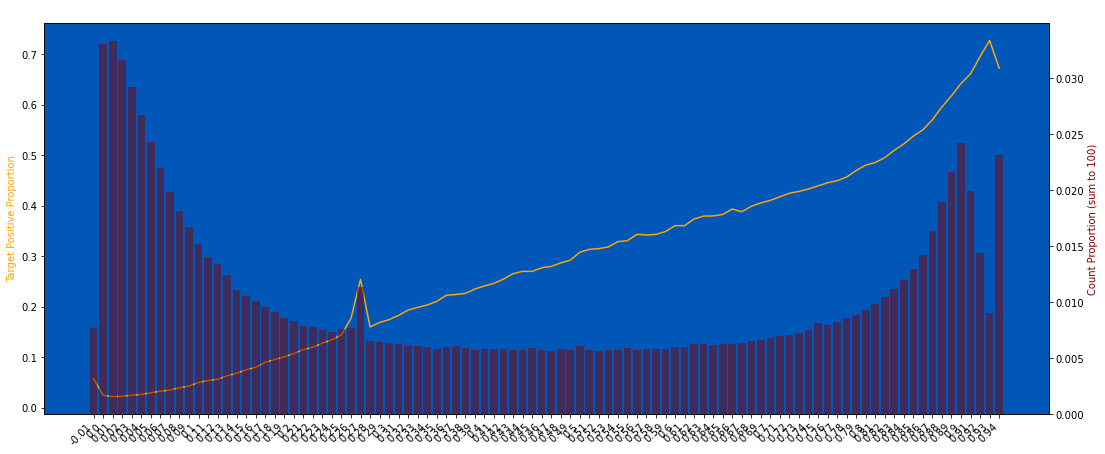

In [164]:
plot_target_check(train, "D_61", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [165]:
# plot_train_test_distribution(df_list, "D_61", nunique_thr=1000)

### D_62 (Done)

In [166]:
# plot_target_check(train, "D_62", q=50, use_raw_bin=True)

In [167]:
%%time
df_list = round_dfs(df_list, col="D_62", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0404
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0387
CPU times: user 2.42 s, sys: 3.14 s, total: 5.56 s
Wall time: 9.12 s


In [168]:
print_percentile(df_list, "D_62", 99.9)

99.9th percentile:
train : 1.63
public test : 1.63
private test : 1.63


In [169]:
for df in df_list:
    df = clip_col(df, "D_62", top_value=1.63, add_new_col=False)

758161 null count, 0.137 null proportion
0.1127 of the targets have label = 1


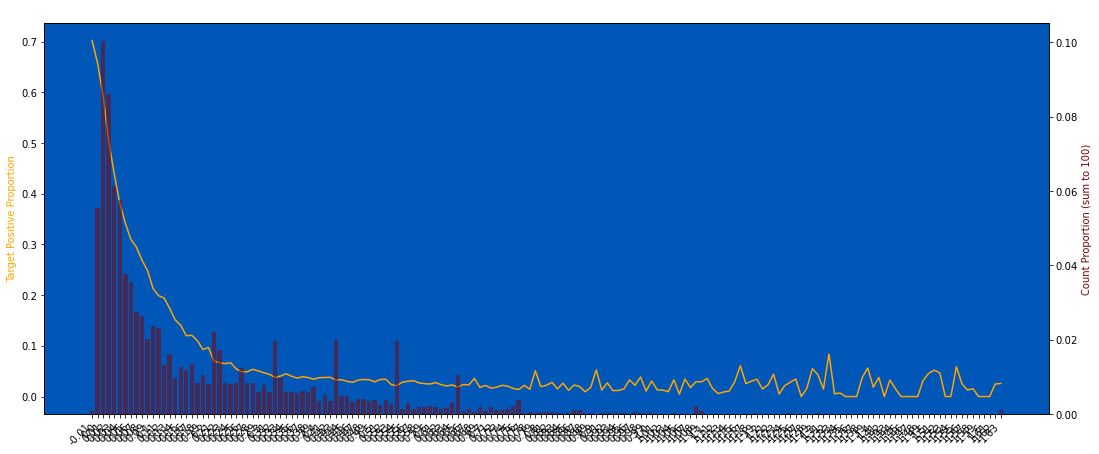

In [170]:
plot_target_check(train, "D_62", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [171]:
# plot_train_test_distribution(df_list, "D_62", nunique_thr=1000)

### D_63 (Done Category)

In [172]:
mapping = dict(train.groupby(["D_63"])["target"].mean())
mapping

{'CL': 0.2908939528730126,
 'CO': 0.2628171377901025,
 'CR': 0.16986495479678712,
 'XL': 0.3174443646805456,
 'XM': 0.23740053050397877,
 'XZ': 0.19091755216008688}

In [173]:
for df in df_list:
    df["D_63"] = df["D_63"].map(mapping)

In [174]:
for df in df_list:
    df["D_63"] = df["D_63"].astype("category").cat.codes

0 null count, 0.000 null proportion
nan of the targets have label = 1


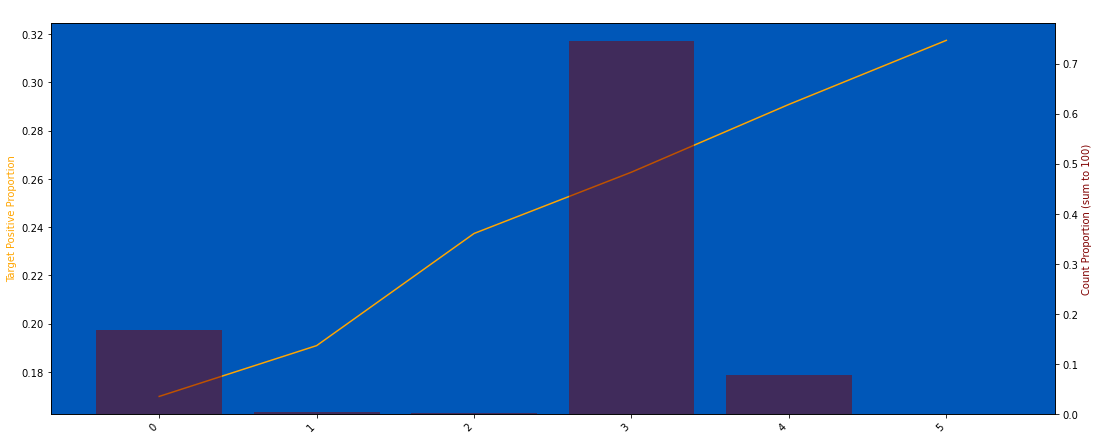

In [175]:
plot_target_check(train, "D_63", q=50, use_raw_bin=True, strfy_x=True, without_drop_tail=True)

Train-Public PSI: 0.0047, Train-Private PSI: 0.0094


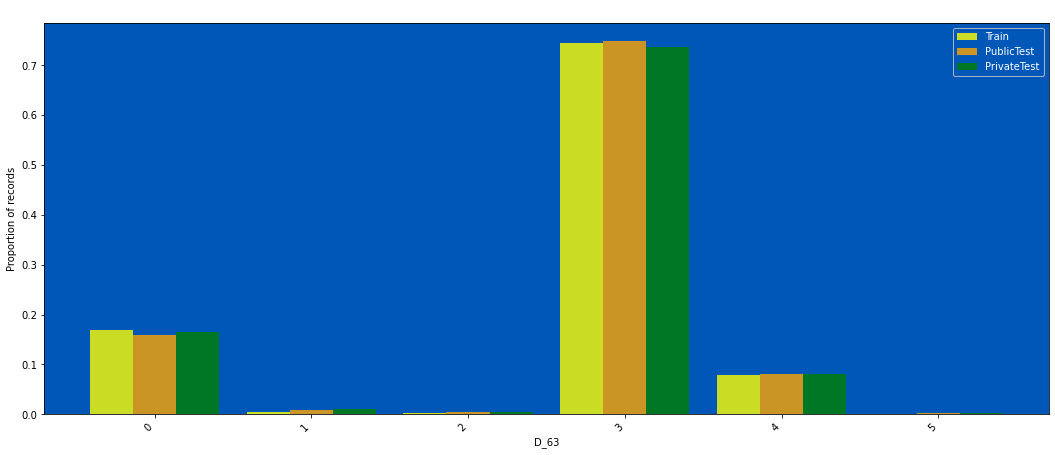

In [176]:
# plot_train_test_distribution(df_list, "D_63", nunique_thr=1000, without_drop_tail=True)

### D_64 (Done Category)

In [177]:
train["D_64"] = train["D_64"].replace("-1", np.nan)

In [178]:
mapping = dict(train.groupby(["D_64"])["target"].mean())
mapping

{'O': 0.16925461787615456, 'R': 0.31524249147732686, 'U': 0.3432227420955622}

In [179]:
for df in df_list:
    df["D_64"] = df["D_64"].map(mapping)

In [180]:
for df in df_list:
    df["D_64"] = df["D_64"].astype("category").cat.codes

Train-Public PSI: 0.0055, Train-Private PSI: 0.0151


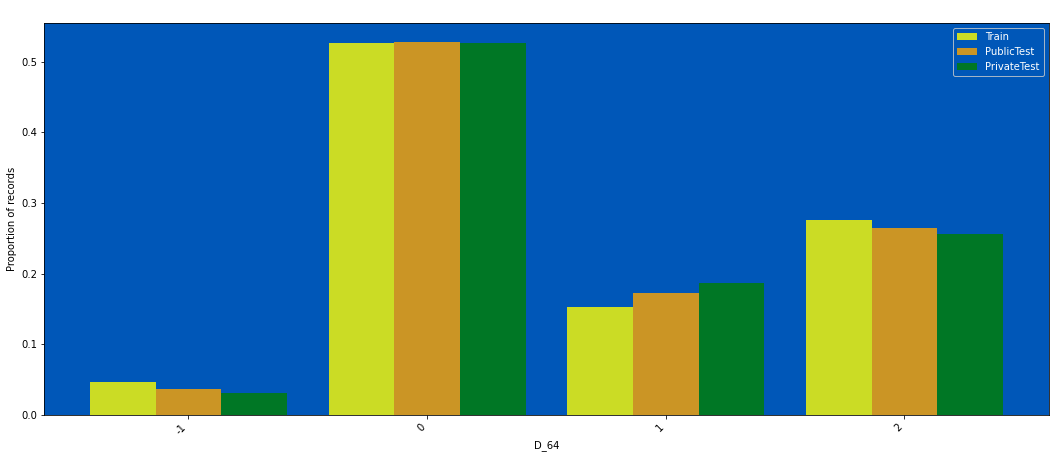

In [181]:
# plot_train_test_distribution(df_list, "D_64", nunique_thr=1000, without_drop_tail=True)

### D_65 (Done)

In [182]:
# plot_target_check(train, "D_65", q=200, use_raw_bin=True, nunique_thr=1000)

In [183]:
%%time
df_list = round_dfs(df_list, col="D_65", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0525
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0519
CPU times: user 2.81 s, sys: 4 s, total: 6.81 s
Wall time: 19.7 s


In [184]:
for df in df_list:
    df["D_65"] = df["D_65"].replace(0, np.nan)

In [185]:
print_percentile(df_list, "D_65", 97)

97th percentile:
train : 3.5
public test : 3.24
private test : 3.37


In [186]:
for df in df_list:
    df = clip_col(df, "D_65", top_value=1, add_new_col=False)

5293716 null count, 0.957 null proportion
0.2315 of the targets have label = 1


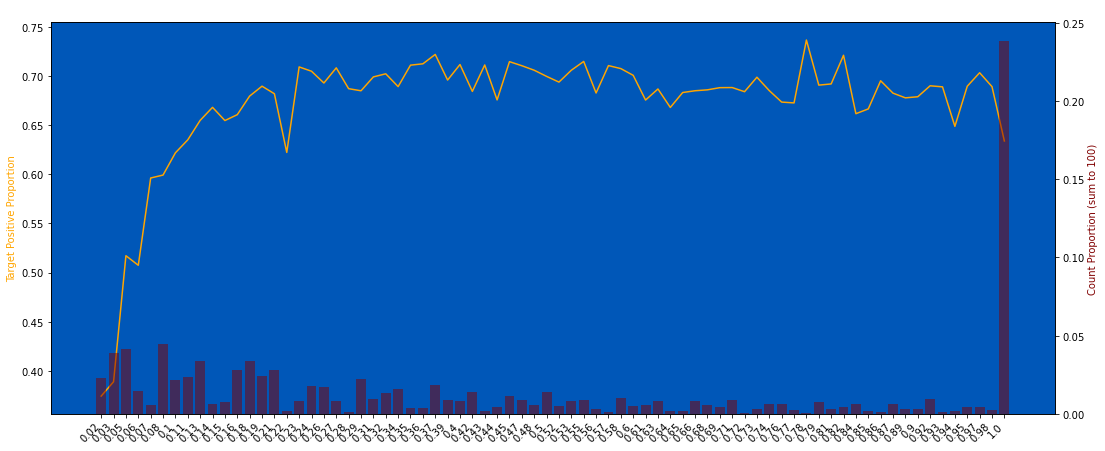

In [187]:
plot_target_check(train, "D_65", q=200, use_raw_bin=True, nunique_thr=10000, strfy_x=True)

Train-Public PSI: 0.0002, Train-Private PSI: 0.0001
Bottom 1% and Top 1% are dropped from this chart


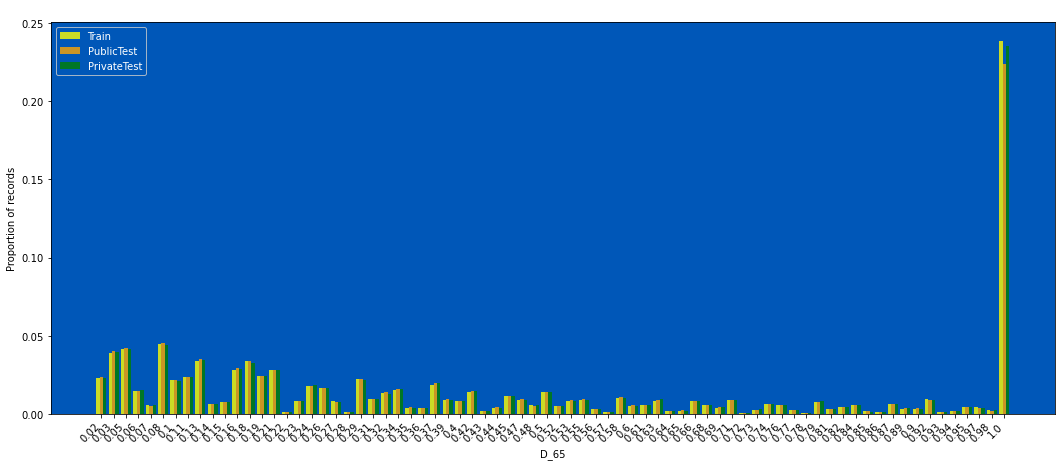

In [188]:
# plot_train_test_distribution(df_list, "D_65", nunique_thr=10000)

### D_66 (Drop)

In [189]:
# plot_target_check(train, "D_66", q=50, use_raw_bin=True, nunique_thr=50, without_drop_tail=True)

In [190]:
# plot_train_test_distribution(df_list, "D_66", nunique_thr=1000)

In [191]:
private_test["D_66"].value_counts()

1.0000    681084
Name: D_66, dtype: int64

In [192]:
%%time
for df in tqdm(df_list):
    df = df.drop(columns="D_66", errors="ignore")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:20<00:00,  6.69s/it]

CPU times: user 1.15 s, sys: 7.62 s, total: 8.77 s
Wall time: 20.1 s


### D_68 (Done Category)

In [193]:
train["D_68"] = train["D_68"].replace(0, 6)

In [194]:
mapping = dict(train.groupby(["D_68"])["target"].mean())
mapping

{1.0: 0.4039903246645934,
 2.0: 0.3929017632012939,
 3.0: 0.3697800768719475,
 4.0: 0.3436032414965202,
 5.0: 0.26221887882726724,
 6.0: 0.17497909504784911}

In [195]:
for df in df_list:
    df["D_68"] = df["D_68"].map(mapping)

216503 null count, 0.039 null proportion
0.4145 of the targets have label = 1


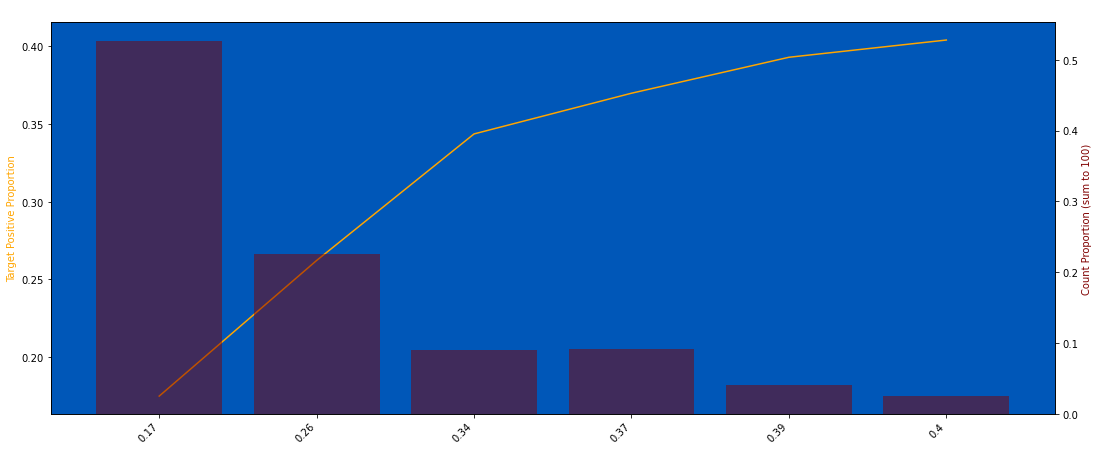

In [196]:
plot_target_check(train, "D_68", q=50, use_raw_bin=True, nunique_thr=50, strfy_x=True, without_drop_tail=True)

In [197]:
for df in df_list:
    df["D_68"] = df["D_68"].astype("category").cat.codes

Train-Public PSI: 0.0021, Train-Private PSI: 0.0054


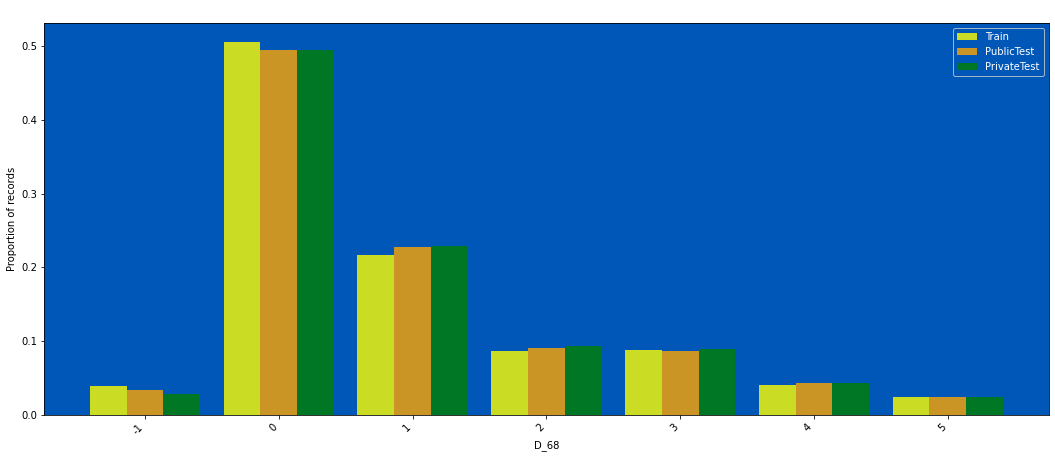

In [198]:
# plot_train_test_distribution(df_list, "D_68", nunique_thr=1000, without_drop_tail=True)

### D_69 (Done Binary)

In [199]:
# plot_target_check(train, "D_69", q=50, use_raw_bin=True)

In [200]:
%%time
df_list = round_dfs(df_list, col="D_69", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0191
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0191
CPU times: user 2.8 s, sys: 3.99 s, total: 6.79 s
Wall time: 16.5 s


In [201]:
for df in df_list:
    df["D_69"] = df["D_69"].fillna(1)
    df["D_69"] = np.where(df["D_69"] > 0, 1, 0)

0 null count, 0.000 null proportion
nan of the targets have label = 1


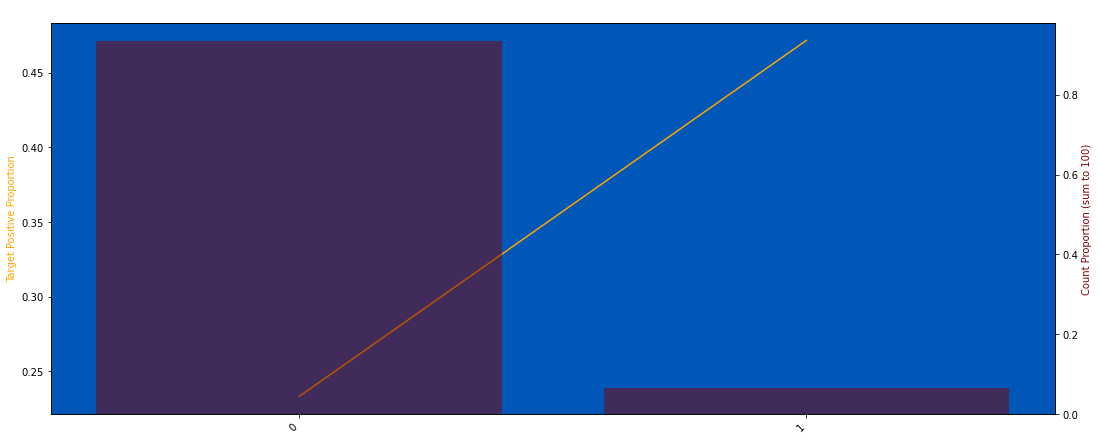

In [202]:
plot_target_check(train, "D_69", q=100, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [203]:
# plot_train_test_distribution(df_list, "D_69", nunique_thr=5000)

### D_70 (Done Integer)

In [204]:
# plot_target_check(train, "D_70", q=50, use_raw_bin=True)

In [205]:
%%time
df_list = round_dfs(df_list, col="D_70", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0045
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0019
CPU times: user 2.59 s, sys: 3.69 s, total: 6.28 s
Wall time: 14 s


In [206]:
for df in df_list:
    df["D_70"] = (df["D_70"] * 4).round(0)

In [207]:
print_percentile(df_list, "D_70", 99.9)

99.9th percentile:
train : 8.0
public test : 8.0
private test : 8.0


In [208]:
for df in df_list:
    df = clip_col(df, "D_70", top_value=8, add_new_col=False)

94917 null count, 0.017 null proportion
0.4203 of the targets have label = 1


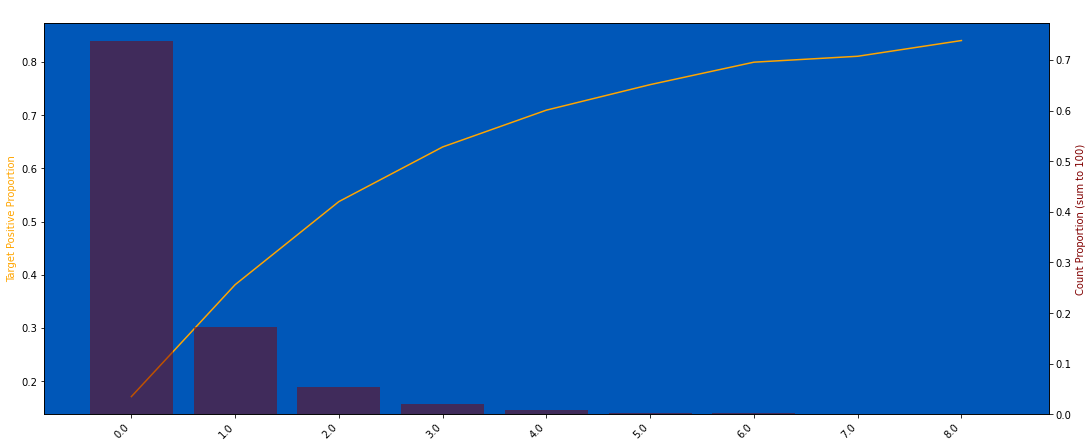

In [209]:
plot_target_check(train, "D_70", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [210]:
# plot_train_test_distribution(df_list, "D_70", nunique_thr=5000, without_drop_tail=True)

### D_71 (KIV) Slight Drift

In [211]:
# plot_target_check(train, "D_71", q=50, use_raw_bin=True)

In [212]:
%%time
df_list = round_dfs(df_list, col="D_71", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0995
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.1008
CPU times: user 2.93 s, sys: 3.6 s, total: 6.53 s
Wall time: 12.4 s


In [213]:
describe_all(df_list, "D_71")

,train,public test,private test
count,"5,531,451.0000","5,719,469.0000","5,644,293.0000"
mean,0.0658,0.0669,0.0701
std,0.3260,0.3309,0.3335
min,0.0000,0.0000,0.0000
25%,0.0000,0.0000,0.0000
50%,0.0100,0.0100,0.0100
75%,0.0300,0.0200,0.0300
max,67.0300,67.0200,59.3500
null_proportion,0.0000,0.0000,0.0000


In [214]:
for df in df_list:
    df["D_71"] = df["D_71"].replace(0.01, np.nan)
    df["D_71"] = df["D_71"].replace(0, 0.01)

In [215]:
print_percentile(df_list, "D_71", 99.5)

99.5th percentile:
train : 1.92
public test : 1.97
private test : 2.02


In [216]:
for df in df_list:
    df = clip_col(df, "D_71", top_value=2, add_new_col=False)

1989047 null count, 0.360 null proportion
0.2427 of the targets have label = 1


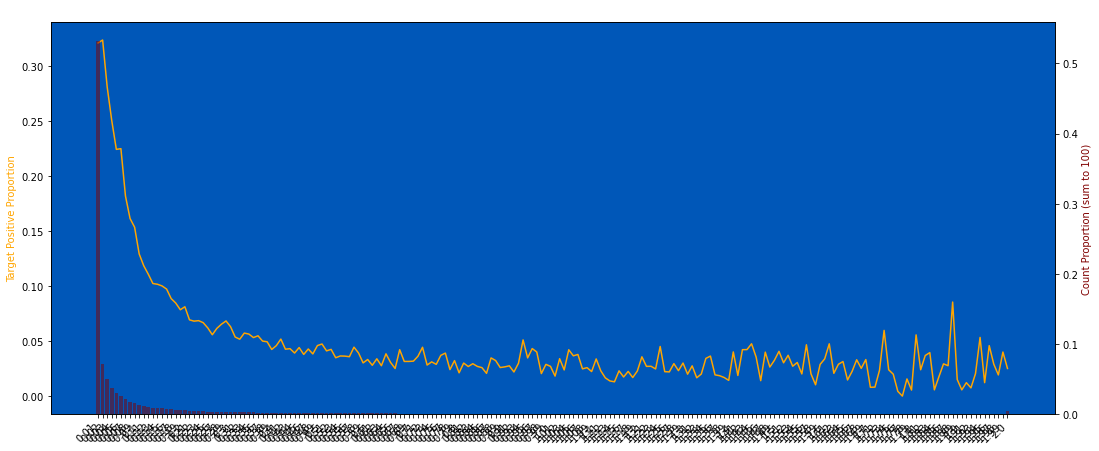

In [217]:
plot_target_check(train, "D_71", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [218]:
# plot_train_test_distribution(df_list, "D_71", nunique_thr=5000)

### D_72 (Done Integer)

In [219]:
# plot_target_check(train, "D_72", q=50, use_raw_bin=True)

In [220]:
%%time
df_list = round_dfs(df_list, col="D_72", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0006
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0006
CPU times: user 2.41 s, sys: 3.55 s, total: 5.96 s
Wall time: 13.1 s


In [221]:
for df in df_list:
    df["D_72"] = (df["D_72"] * 3).round(0)

In [222]:
print_percentile(df_list, "D_72", 99.9)

99.9th percentile:
train : 9.0
public test : 9.0
private test : 9.0


In [223]:
for df in df_list:
    df = clip_col(df, "D_72", top_value=9, add_new_col=False)

23708 null count, 0.004 null proportion
0.3495 of the targets have label = 1


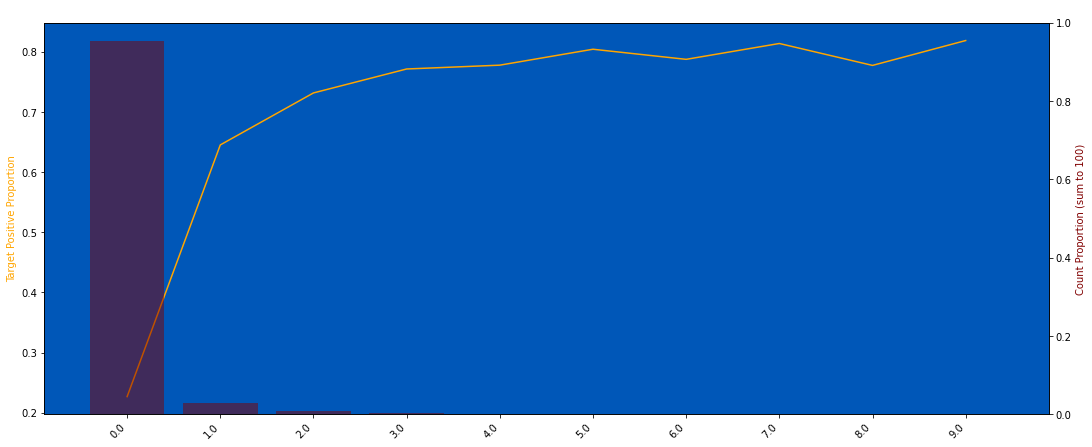

In [224]:
plot_target_check(train, "D_72", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [225]:
# plot_train_test_distribution(df_list, "D_72", nunique_thr=5000, without_drop_tail=True)

### D_73 (Drop)

In [226]:
# plot_target_check(train, "D_73", q=50, use_raw_bin=True)

In [227]:
%%time
df_list = round_dfs(df_list, col="D_73", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.1174
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0537
CPU times: user 1.7 s, sys: 3.37 s, total: 5.07 s
Wall time: 11 s


In [228]:
# plot_target_check(train, "D_73", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Train-Public PSI: 0.0450, Train-Private PSI: 0.0537
Bottom 1% and Top 1% are dropped from this chart


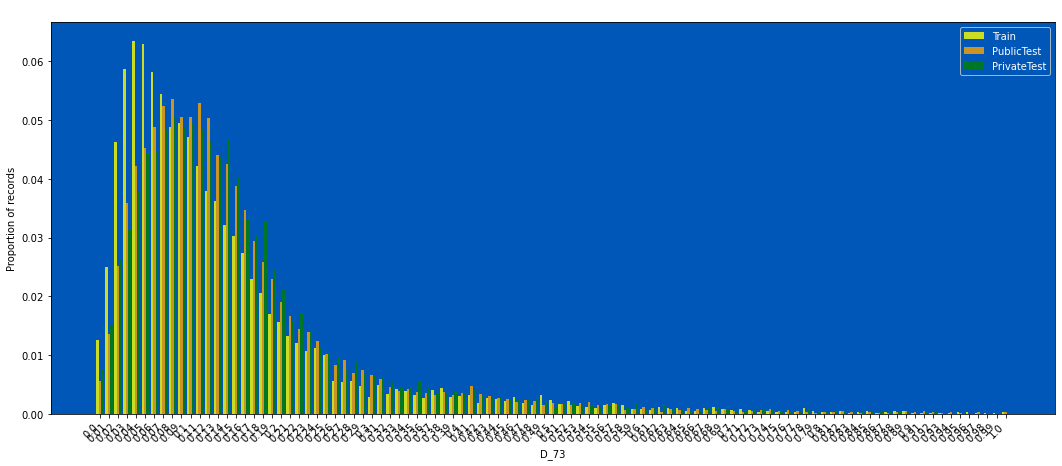

In [229]:
plot_train_test_distribution(df_list, "D_73", nunique_thr=5000)

In [230]:
%%time
for df in df_list:
    df = df.drop(columns="D_73", errors="ignore")

CPU times: user 1.16 s, sys: 7.89 s, total: 9.05 s
Wall time: 20 s


### D_74 (Done Integer)

In [231]:
# plot_target_check(train, "D_74", q=50, use_raw_bin=True)

In [232]:
%%time
df_list = round_dfs(df_list, col="D_74", decimals=3, add_new_col=False)

Before round, Train-Private PSI = 0.0145
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0145
CPU times: user 2.8 s, sys: 3.78 s, total: 6.58 s
Wall time: 14.7 s


In [233]:
%%time
for df in df_list:
    df["D_74"] = (df["D_74"] / 0.071)
df_list = round_dfs(df_list, col="D_74", decimals=0, add_new_col=False)

Before round, Train-Private PSI = 0.0145
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0044
CPU times: user 1.59 s, sys: 1.28 s, total: 2.87 s
Wall time: 4.8 s


In [234]:
print_percentile(df_list, "D_74", 99.9)

99.9th percentile:
train : 23.0
public test : 23.0
private test : 23.0


In [235]:
for df in df_list:
    df = clip_col(df, "D_74", top_value=25, add_new_col=False)

21773 null count, 0.004 null proportion
0.1709 of the targets have label = 1


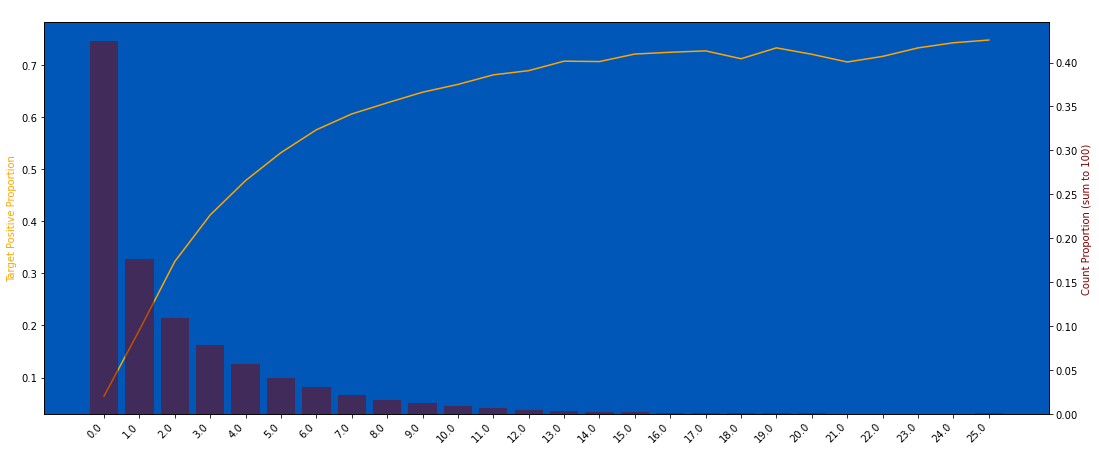

In [236]:
plot_target_check(train, "D_74", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [237]:
# plot_train_test_distribution(df_list, "D_74", nunique_thr=5000, without_drop_tail=True)

### D_75 (Done Integer)

In [238]:
# plot_target_check(train, "D_75", q=50, use_raw_bin=True)

In [239]:
%%time
df_list = round_dfs(df_list, col="D_75", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0157
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0060
CPU times: user 2.81 s, sys: 3.67 s, total: 6.48 s
Wall time: 10.2 s


In [240]:
for df in df_list:
    df["D_75"] = (df["D_75"] * (100 / 6.66)).round(0)

In [241]:
print_percentile(df_list, "D_75", 99.9)

99.9th percentile:
train : 24.0
public test : 24.0
private test : 25.0


In [242]:
for df in df_list:
    df = clip_col(df, "D_75", top_value=25, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


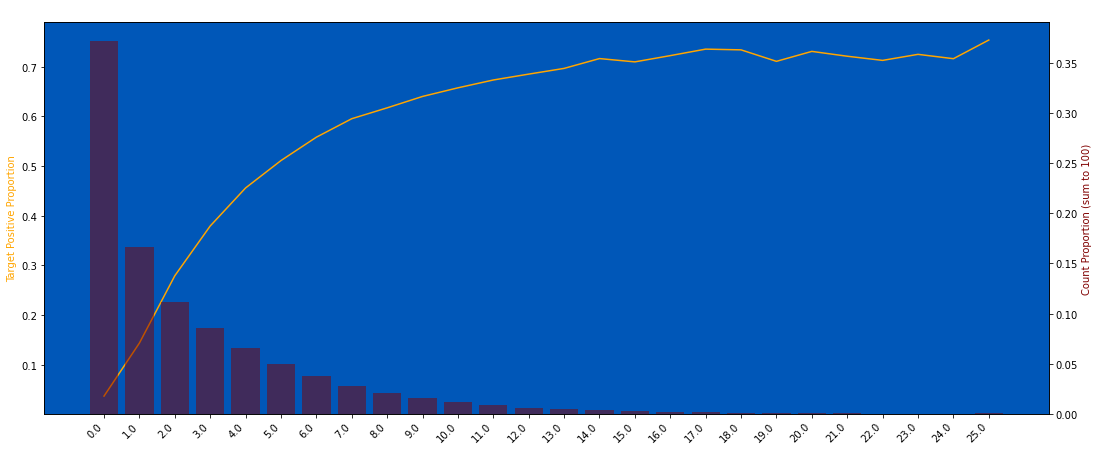

In [243]:
plot_target_check(train, "D_75", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True, without_drop_tail=True)

In [244]:
# plot_train_test_distribution(df_list, "D_75", nunique_thr=5000, without_drop_tail=True)

### D_76 (Done)

In [245]:
# plot_target_check(train, "D_76", q=50, use_raw_bin=True)

In [246]:
%%time
df_list = round_dfs(df_list, col="D_76", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0986
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0999
CPU times: user 1.55 s, sys: 3.48 s, total: 5.03 s
Wall time: 7.15 s


In [247]:
print_percentile(df_list, "D_76", 99)

99th percentile:
train : 1.0
public test : 1.07
private test : 1.14


In [248]:
for df in df_list:
    df = clip_col(df, "D_76", top_value=1, add_new_col=False)

4908954 null count, 0.887 null proportion
0.2677 of the targets have label = 1


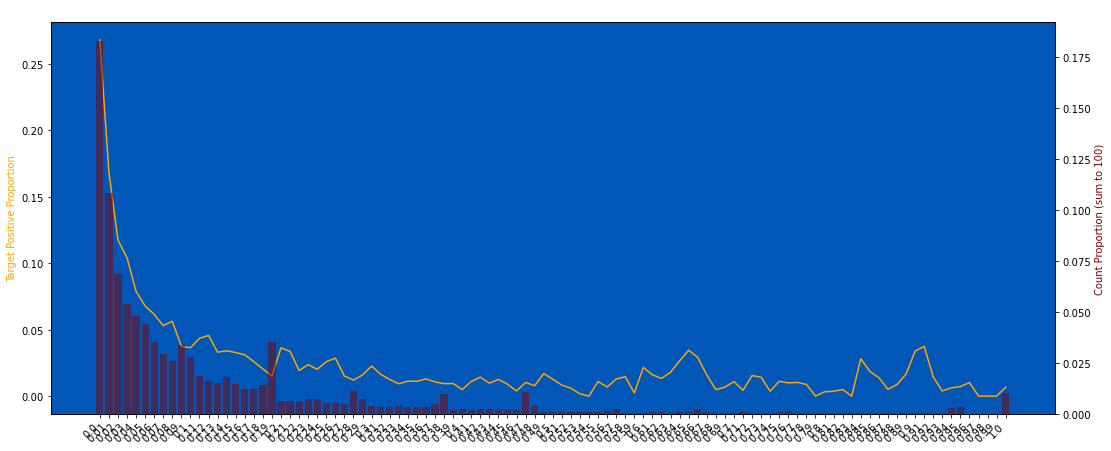

In [249]:
plot_target_check(train, "D_76", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True)

In [250]:
# plot_train_test_distribution(df_list, "D_76", nunique_thr=5000)

### D_77 (Done)

In [251]:
# plot_target_check(train, "D_77", q=50, use_raw_bin=True)

In [252]:
%%time
df_list = round_dfs(df_list, col="D_77", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0385
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0321
CPU times: user 1.93 s, sys: 2.37 s, total: 4.3 s
Wall time: 6.77 s


In [253]:
print_percentile(df_list, "D_77", 99.3)

99.3th percentile:
train : 1.05
public test : 1.05
private test : 1.06


In [254]:
for df in df_list:
    df = clip_col(df, "D_77", top_value=1.01, add_new_col=False)

2513912 null count, 0.454 null proportion
0.3395 of the targets have label = 1


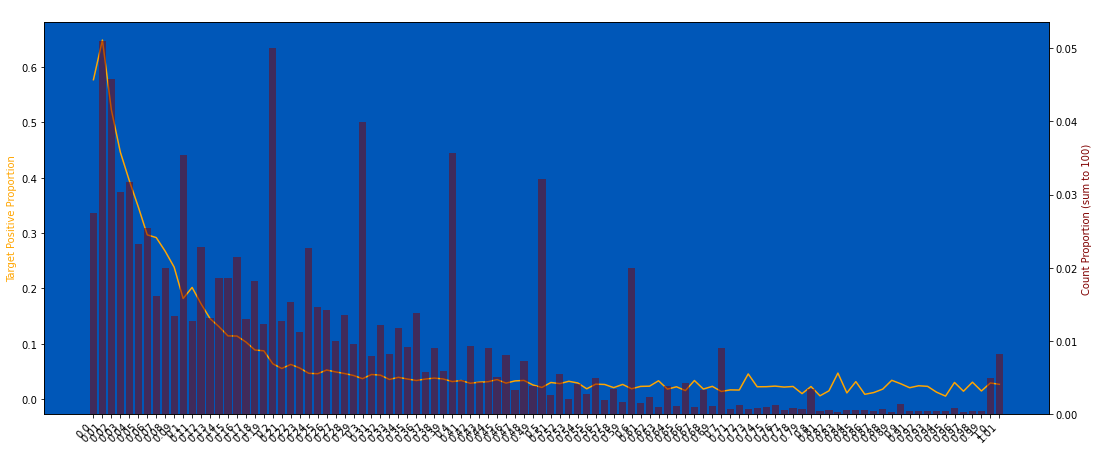

In [255]:
plot_target_check(train, "D_77", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True, without_drop_tail=True)

In [256]:
# plot_train_test_distribution(df_list, "D_77", nunique_thr=5000)

### D_78 (Done Integer)

In [257]:
# plot_target_check(train, "D_78", q=50, use_raw_bin=True)

In [258]:
%%time
df_list = round_dfs(df_list, col="D_78", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0040
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0020
CPU times: user 2.41 s, sys: 3.32 s, total: 5.72 s
Wall time: 10.7 s


In [259]:
for df in df_list:
    df["D_78"] = (df["D_78"] * 2).round(0)

In [260]:
print_percentile(df_list, "D_78", 99.9)

99.9th percentile:
train : 6.0
public test : 6.0
private test : 6.0


In [261]:
for df in df_list:
    df = clip_col(df, "D_78", top_value=6, add_new_col=False)

274319 null count, 0.050 null proportion
0.2406 of the targets have label = 1


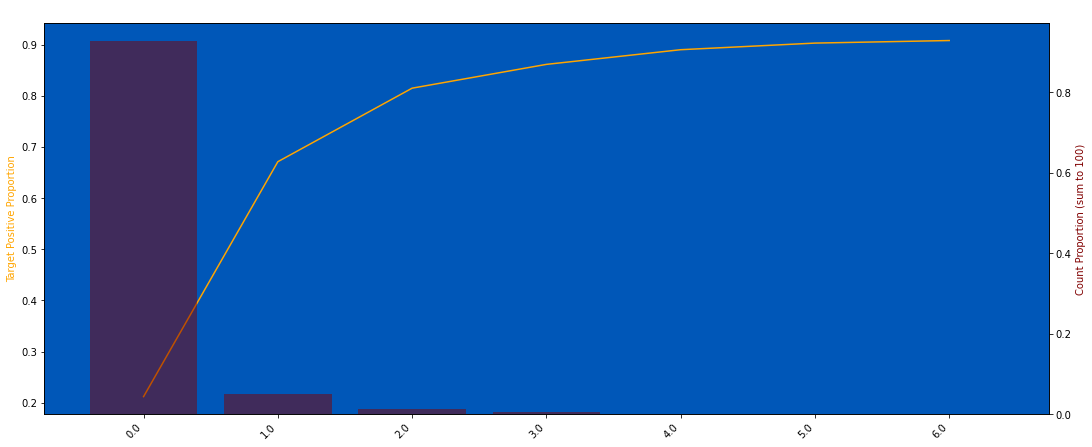

In [262]:
plot_target_check(train, "D_78", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

In [263]:
# plot_train_test_distribution(df_list, "D_78", nunique_thr=500, without_drop_tail=True)

### D_79 (Done Integer)

In [264]:
# plot_target_check(train, "D_79", q=50, use_raw_bin=True)

In [265]:
%%time
df_list = round_dfs(df_list, col="D_79", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0121
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0115
CPU times: user 2.51 s, sys: 2.75 s, total: 5.26 s
Wall time: 6.79 s


In [266]:
for df in df_list:
    df["D_79"] = (df["D_79"] * 2).round(0)

In [267]:
print_percentile(df_list, "D_79", 99.7)

99.7th percentile:
train : 3.0
public test : 3.0
private test : 3.0


In [268]:
for df in df_list:
    df = clip_col(df, "D_79", top_value=4, add_new_col=False)

75939 null count, 0.014 null proportion
0.3761 of the targets have label = 1


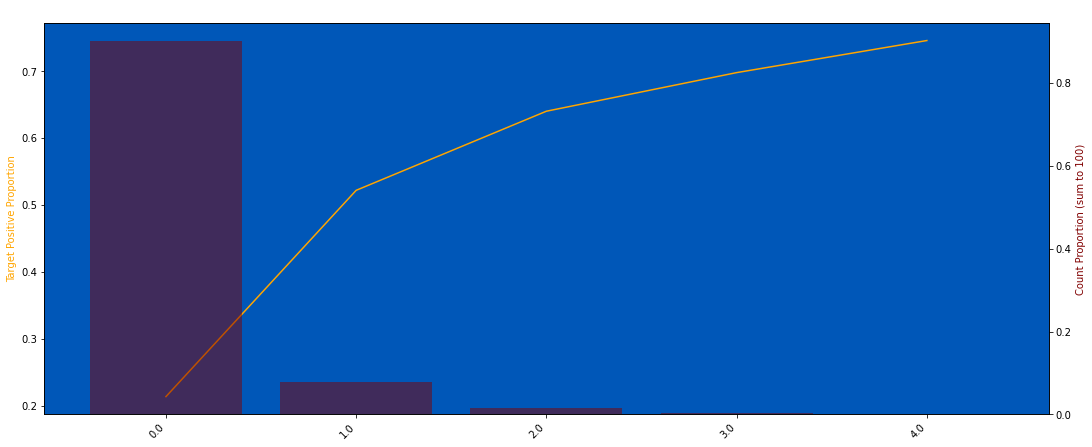

In [269]:
plot_target_check(train, "D_79", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

In [270]:
# plot_train_test_distribution(df_list, "D_79", nunique_thr=500, without_drop_tail=True)

### D_80 (Done Integer)

In [271]:
# plot_target_check(train, "D_80", q=50, use_raw_bin=True)

In [272]:
%%time
df_list = round_dfs(df_list, col="D_80", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0063
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0027
CPU times: user 2.48 s, sys: 3.02 s, total: 5.49 s
Wall time: 6.63 s


In [273]:
for df in df_list:
    df["D_80"] = (df["D_80"] * 5).round(0)

In [274]:
print_percentile(df_list, "D_80", 99.9)

99.9th percentile:
train : 9.0
public test : 9.0
private test : 9.0


In [275]:
for df in df_list:
    df = clip_col(df, "D_80", top_value=9, add_new_col=False)

21773 null count, 0.004 null proportion
0.1709 of the targets have label = 1


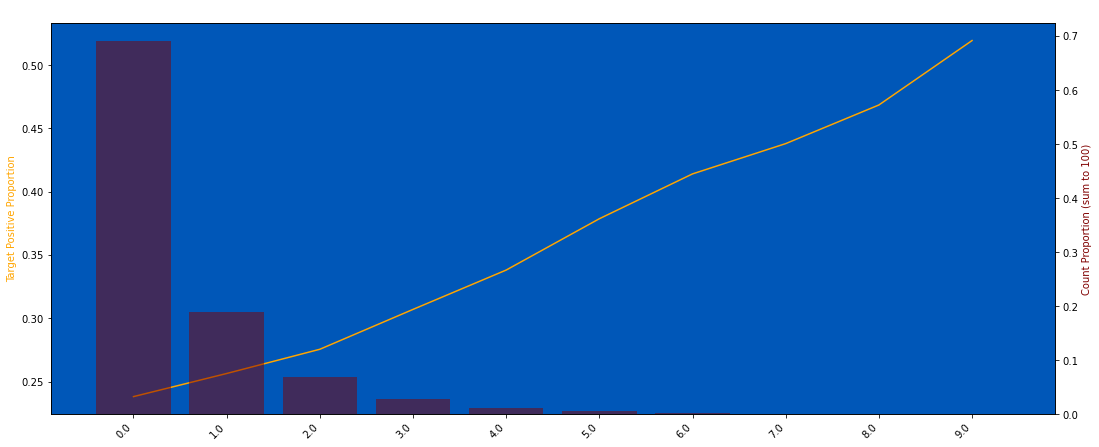

In [276]:
plot_target_check(train, "D_80", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True, without_drop_tail=True)

In [277]:
# plot_train_test_distribution(df_list, "D_80", nunique_thr=500, without_drop_tail=True)

### D_81 (Done Integer)

In [278]:
# plot_target_check(train, "D_81", q=50, use_raw_bin=True)

In [279]:
%%time
df_list = round_dfs(df_list, col="D_81", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0003
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0003
CPU times: user 2.5 s, sys: 2.24 s, total: 4.74 s
Wall time: 6.93 s


In [280]:
print_percentile(df_list, "D_81", 99.9)

99.9th percentile:
train : 5.0
public test : 5.0
private test : 5.0


In [281]:
for df in df_list:
    df = clip_col(df, "D_81", top_value=5, add_new_col=False)

25687 null count, 0.005 null proportion
0.3798 of the targets have label = 1


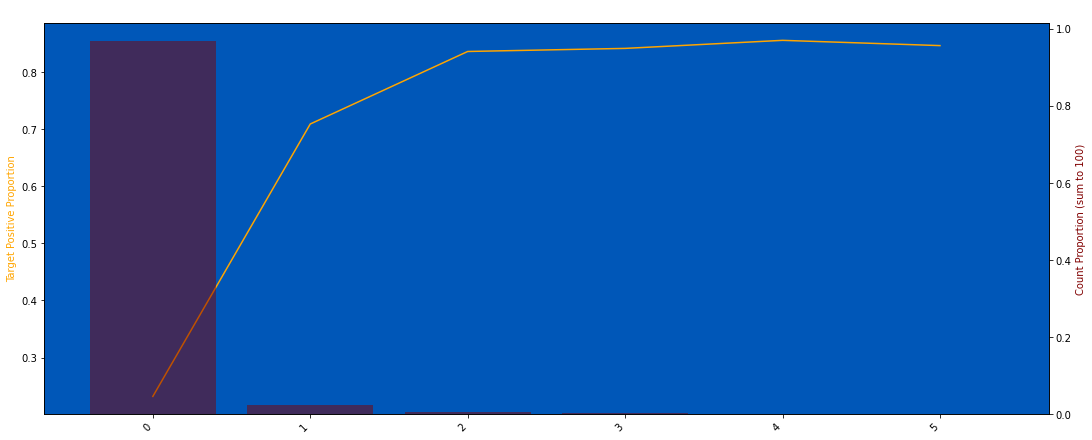

In [282]:
plot_target_check(train, "D_81", q=50, use_raw_bin=True, without_drop_tail=True)

In [283]:
# plot_train_test_distribution(df_list, "D_81", nunique_thr=500, without_drop_tail=True)

### D_82 (Done Integer)

In [284]:
# plot_target_check(train, "D_82", q=50, use_raw_bin=True)

In [285]:
%%time
df_list = round_dfs(df_list, col="D_82", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0027
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0021
CPU times: user 2 s, sys: 2.04 s, total: 4.05 s
Wall time: 5.33 s


In [286]:
for df in df_list:
    df["D_82"] = (df["D_82"] * 2).round(0)

In [287]:
print_percentile(df_list, "D_82", 99.9)

99.9th percentile:
train : 3.0
public test : 3.0
private test : 3.0


In [288]:
for df in df_list:
    df = clip_col(df, "D_82", top_value=2, add_new_col=False)

4058614 null count, 0.734 null proportion
0.2648 of the targets have label = 1


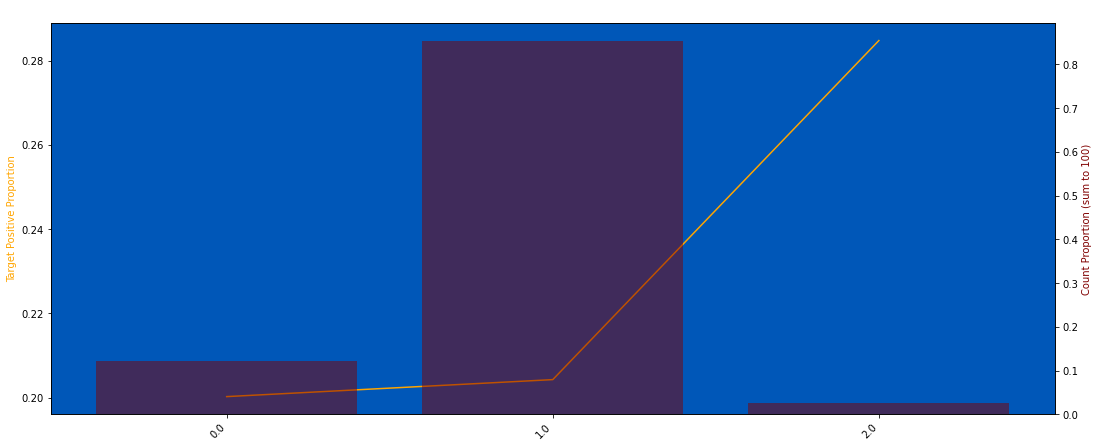

In [289]:
plot_target_check(train, "D_82", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True, without_drop_tail=True)

In [290]:
# plot_train_test_distribution(df_list, "D_82", nunique_thr=500, without_drop_tail=True)

### D_83 (Done Integer)

In [291]:
# plot_target_check(train, "D_83", q=50, use_raw_bin=True)

In [292]:
%%time
df_list = round_dfs(df_list, col="D_83", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0082
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0082
CPU times: user 2.35 s, sys: 2.97 s, total: 5.32 s
Wall time: 6.49 s


In [293]:
print_percentile(df_list, "D_83", 99.7)

99.7th percentile:
train : 2.0
public test : 2.0
private test : 2.0


In [294]:
for df in df_list:
    df = clip_col(df, "D_83", top_value=2, add_new_col=False)

194473 null count, 0.035 null proportion
0.4308 of the targets have label = 1


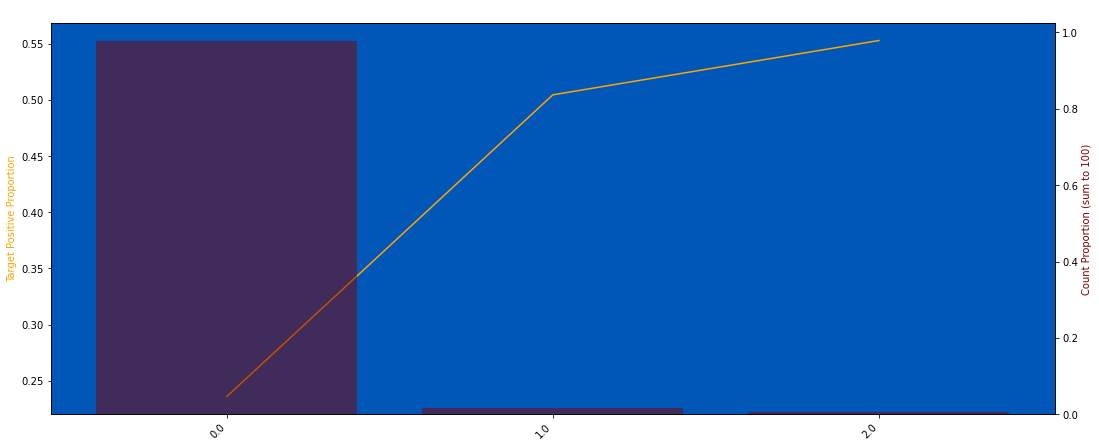

In [295]:
plot_target_check(train, "D_83", q=50, use_raw_bin=True, nunique_thr=3000, strfy_x=True, without_drop_tail=True)

In [296]:
# plot_train_test_distribution(df_list, "D_83", nunique_thr=500, without_drop_tail=True)

### D_84 (Done Integer)

In [297]:
# plot_target_check(train, "D_84", q=50, use_raw_bin=True)

In [298]:
%%time
df_list = round_dfs(df_list, col="D_84", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0044
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0032
CPU times: user 2.48 s, sys: 1.92 s, total: 4.4 s
Wall time: 5.77 s


In [300]:
for df in df_list:
    df["D_84"] = (df["D_84"] * 2).round(0)
    df["D_84"] = df["D_84"].fillna(1)

In [301]:
print_percentile(df_list, "D_84", 99.8)

99.8th percentile:
train : 6.0
public test : 6.0
private test : 6.0


In [302]:
for df in df_list:
    df = clip_col(df, "D_84", top_value=6, add_new_col=False)

0 null count, 0.000 null proportion
nan of the targets have label = 1


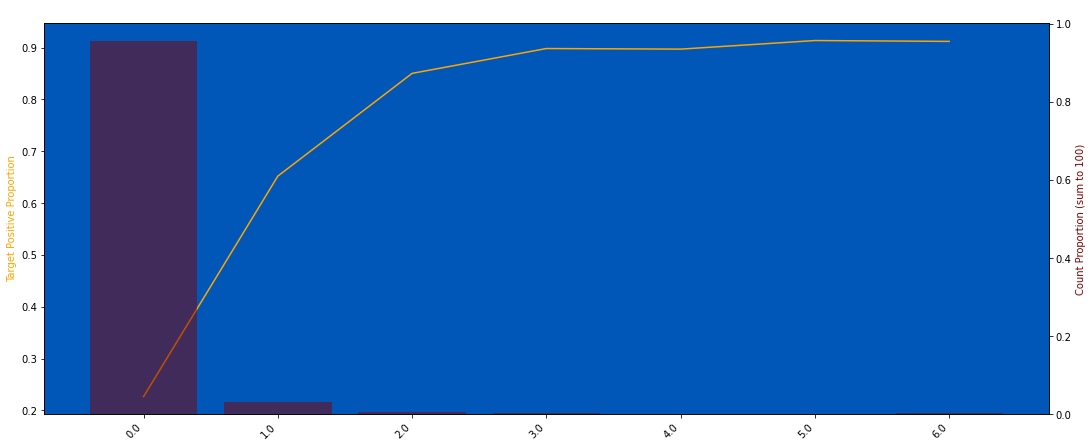

In [303]:
plot_target_check(train, "D_84", q=50, use_raw_bin=True, without_drop_tail=True, strfy_x=True)

In [304]:
# plot_train_test_distribution(df_list, "D_84", nunique_thr=500, without_drop_tail=True)

### D_86 (Done Binary)

In [305]:
# plot_target_check(train, "D_86", q=50, use_raw_bin=True)

In [306]:
%%time
df_list = round_dfs(df_list, col="D_86", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0000
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0000
CPU times: user 2.14 s, sys: 1.75 s, total: 3.89 s
Wall time: 4.88 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


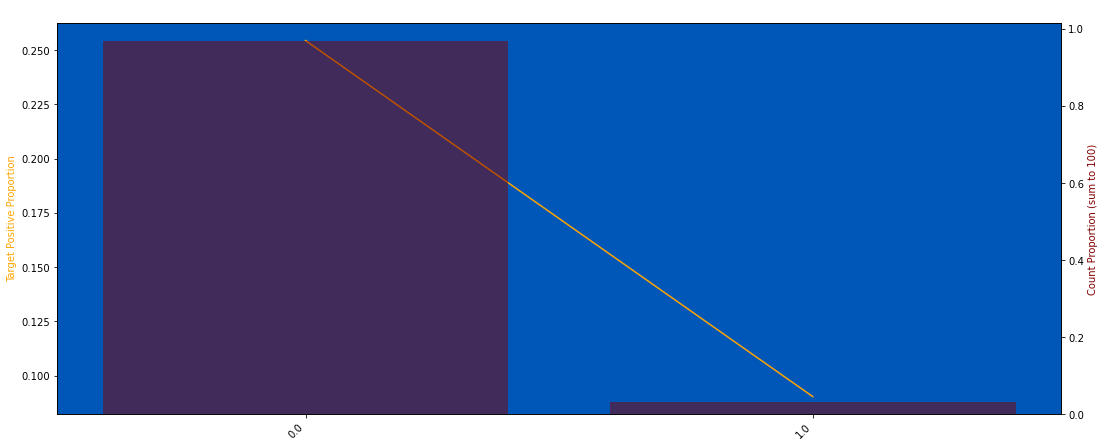

In [307]:
plot_target_check(train, "D_86", q=50, use_raw_bin=True, without_drop_tail=True, nunique_thr=500, strfy_x=True)

In [308]:
# plot_train_test_distribution(df_list, "D_86", nunique_thr=500)

### D_87 (Drop)

In [309]:
# plot_target_check(train, "D_87", q=100, use_raw_bin=True, strfy_x=True, without_drop_tail=True)

In [310]:
# train["D_87"].value_counts(), public_test["D_87"].value_counts(), private_test["D_87"].value_counts()

In [311]:
train.groupby("D_87")["target"].mean()

D_87
1.0000   0.8670
Name: target, dtype: float64

In [312]:
%time
for df in df_list:
    df.drop(columns="D_87", errors="ignore", inplace=True)

CPU times: user 10 µs, sys: 39 µs, total: 49 µs
Wall time: 10 µs


### D_88 (KIV) Drift in Train Test

In [313]:
# plot_target_check(train, "D_88", q=50, use_raw_bin=True)

In [314]:
%%time
df_list = round_dfs(df_list, col="D_88", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0801
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0210
CPU times: user 1.13 s, sys: 1.97 s, total: 3.1 s
Wall time: 4.66 s


In [315]:
print_percentile(df_list, "D_88", 0.12)

0.12th percentile:
train : 0.0
public test : 0.0
private test : 0.0


In [316]:
for df in df_list:
    df["D_88"] = np.where(df["D_88"] < 0, np.nan, df["D_88"])
    # df = clip_col(df, "D_84", top_value=15, add_new_col=False)

In [317]:
print_percentile(df_list, "D_88", 99.5)

99.5th percentile:
train : 1.15
public test : 1.0910000000000037
private test : 1.0762500000000002


In [318]:
for df in df_list:
    df = clip_col(df, "D_88", top_value=1, add_new_col=False)

5525448 null count, 0.999 null proportion
0.2485 of the targets have label = 1


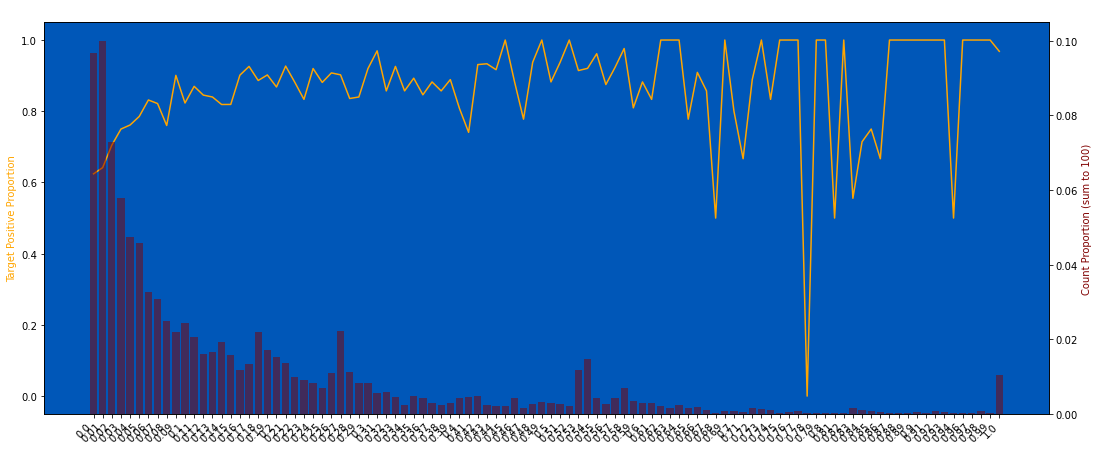

In [319]:
plot_target_check(train, "D_88", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [320]:
# plot_train_test_distribution(df_list, "D_88", nunique_thr=500)

### D_89 (Done Integer)

In [321]:
# plot_target_check(train, "D_89", q=50, use_raw_bin=True, nunique_thr=12)

In [322]:
%%time
df_list = round_dfs(df_list, col="D_89", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0001
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0000
CPU times: user 2.15 s, sys: 1.87 s, total: 4.02 s
Wall time: 5.11 s


In [323]:
for df in df_list:
    df["D_89"] = (df["D_89"] * 100/11).round(0)

In [324]:
print_percentile(df_list, "D_89", 99.99)

99.99th percentile:
train : 6.0
public test : 6.0
private test : 6.0


In [325]:
for df in df_list:
    df = clip_col(df, "D_89", top_value=2, add_new_col=False)

29563 null count, 0.005 null proportion
0.3523 of the targets have label = 1


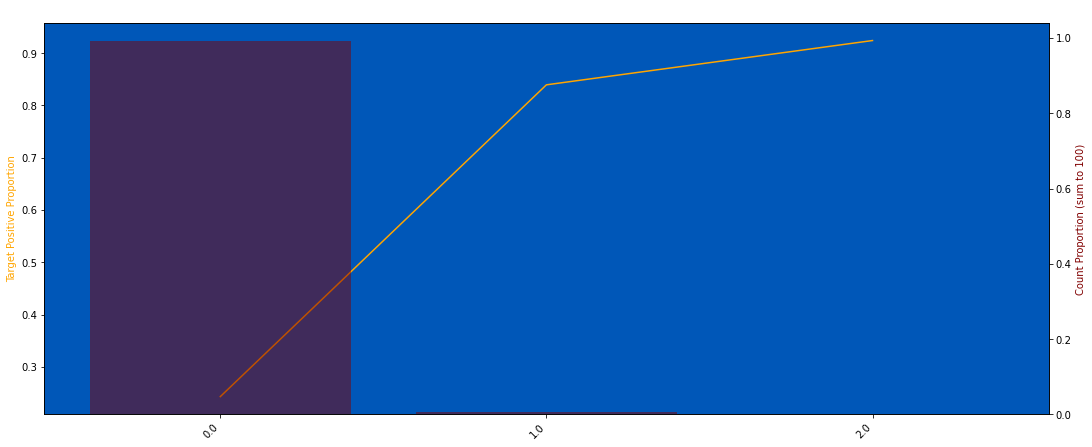

In [326]:
plot_target_check(train, "D_89", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [327]:
# plot_train_test_distribution(df_list, "D_89", nunique_thr=500, without_drop_tail=True)

### D_91 (Done Integer)

In [328]:
# plot_target_check(train, "D_91", q=50, use_raw_bin=True)

In [329]:
%%time
df_list = round_dfs(df_list, col="D_91", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0023
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0012
CPU times: user 2.37 s, sys: 3.12 s, total: 5.49 s
Wall time: 5.25 s


In [330]:
print_percentile(df_list, "D_91", 99.9)

99.9th percentile:
train : 1.5
public test : 1.5
private test : 1.5


In [331]:
for df in df_list:
    df["D_91"] *= 2
    df = clip_col(df, "D_91", top_value=3, add_new_col=False)

157216 null count, 0.028 null proportion
0.4663 of the targets have label = 1


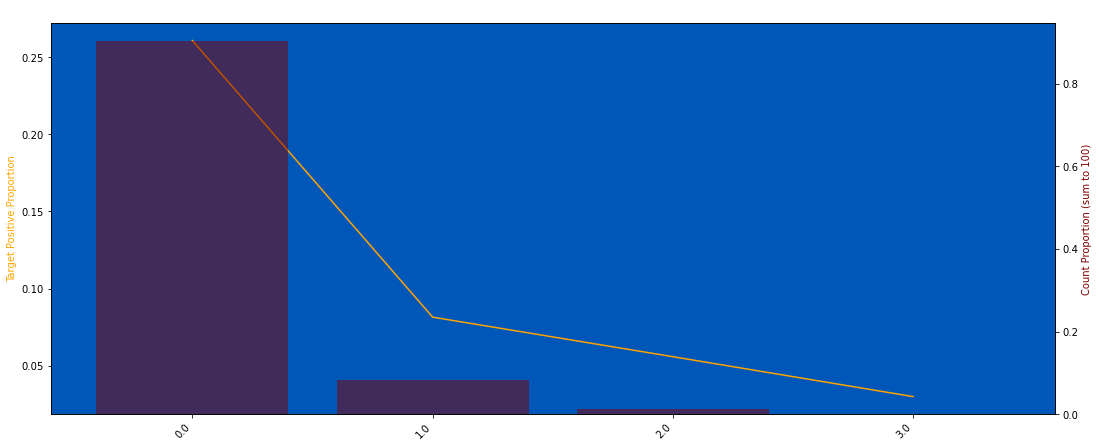

In [332]:
plot_target_check(train, "D_91", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [333]:
# plot_train_test_distribution(df_list, "D_91", nunique_thr=12)

### D_92 (Done Integer)

In [334]:
# plot_target_check(train, "D_92", q=50, use_raw_bin=True)

In [335]:
%%time
df_list = round_dfs(df_list, col="D_92", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0028
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0028
CPU times: user 2.68 s, sys: 2.2 s, total: 4.88 s
Wall time: 5.62 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


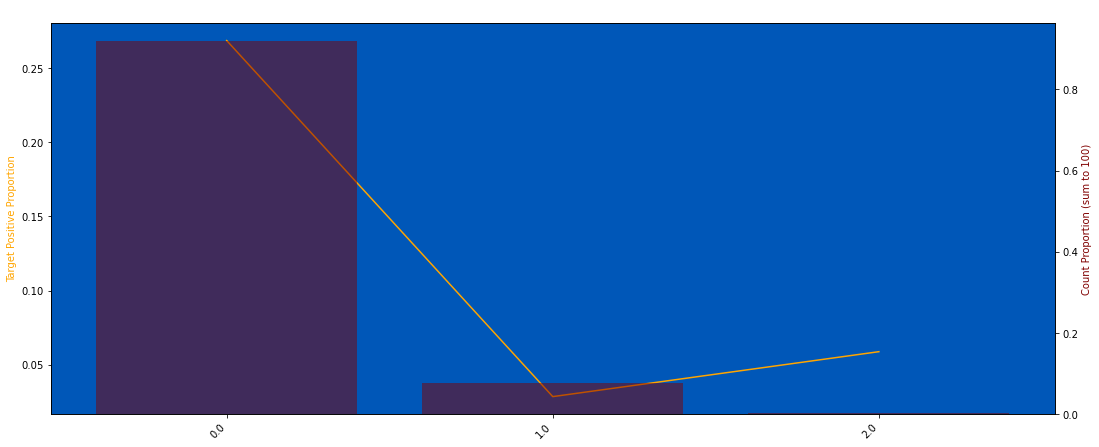

In [336]:
plot_target_check(train, "D_92", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [337]:
# plot_train_test_distribution(df_list, "D_92", nunique_thr=12)

### D_93 (Done Binary)

In [338]:
# plot_target_check(train, "D_93", q=50, use_raw_bin=True)

In [339]:
%%time
df_list = round_dfs(df_list, col="D_93", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0011
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0011
CPU times: user 3.37 s, sys: 2.13 s, total: 5.5 s
Wall time: 5.23 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


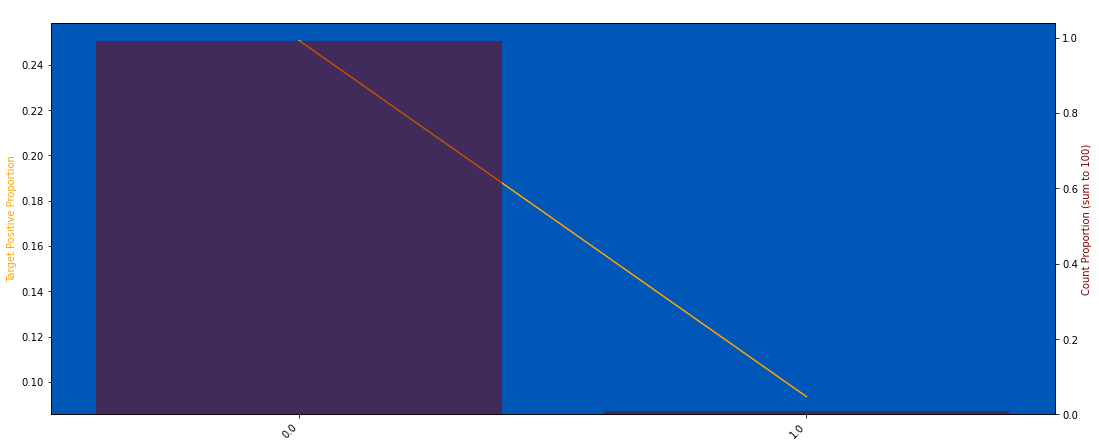

In [340]:
plot_target_check(train, "D_93", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [341]:
# plot_train_test_distribution(df_list, "D_93", nunique_thr=12)

### D_94 (Done Binary)

In [342]:
# plot_target_check(train, "D_94", q=50, use_raw_bin=True)

In [343]:
%%time
df_list = round_dfs(df_list, col="D_94", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0002
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0002
CPU times: user 2.31 s, sys: 2.78 s, total: 5.09 s
Wall time: 5.08 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


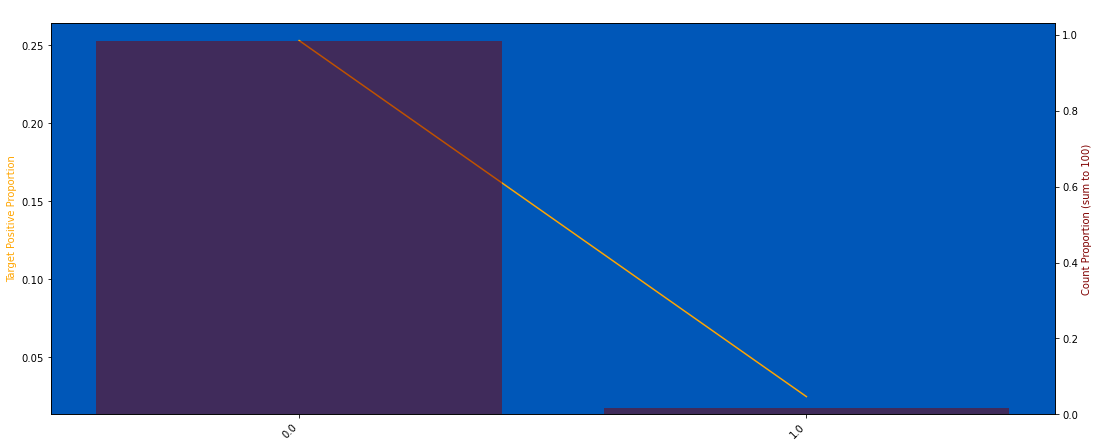

In [344]:
plot_target_check(train, "D_94", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [345]:
# plot_train_test_distribution(df_list, "D_94", nunique_thr=12)

### D_96 (Done Binary)

In [346]:
# plot_target_check(train, "D_96", q=50, use_raw_bin=True)

In [347]:
%%time
df_list = round_dfs(df_list, col="D_96", decimals=2, add_new_col=False)

Before round, Train-Private PSI = 0.0006
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
After round, Train-Private PSI = 0.0005
CPU times: user 2.47 s, sys: 3.2 s, total: 5.67 s
Wall time: 5.61 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


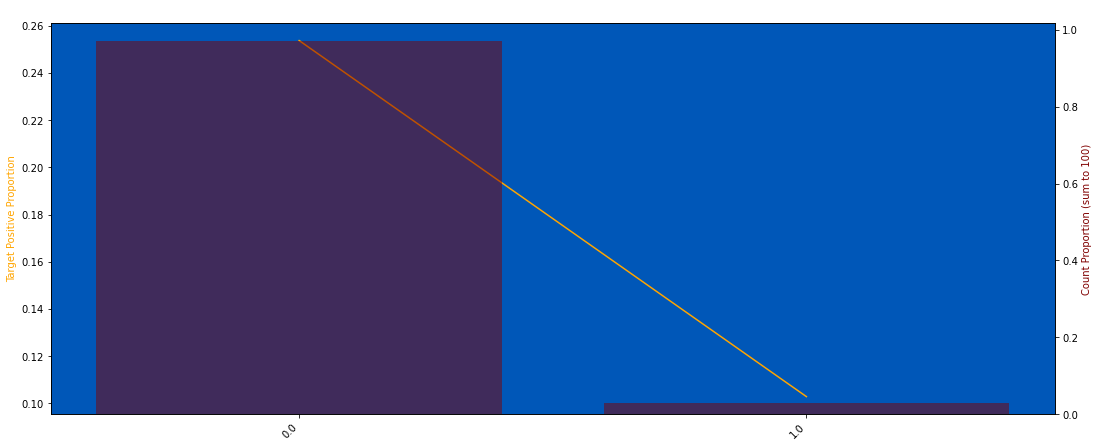

In [348]:
plot_target_check(train, "D_96", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [349]:
# plot_train_test_distribution(df_list, "D_96", nunique_thr=12)

### Column checking

In [350]:
all_columns = get_cols(df_list[0], ["D_"])
print(all_columns)

['D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_66', 'D_68', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'D_86', 'D_88', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96', 'D_60a']


In [351]:
%%time
d_col_nunique = df_list[0][all_columns].nunique()
less_unique_d_cols = d_col_nunique[d_col_nunique < 99].index.tolist()

CPU times: user 1.42 s, sys: 1.97 s, total: 3.39 s
Wall time: 1.98 s


In [352]:
print(less_unique_d_cols)

['D_39', 'D_44', 'D_49', 'D_51', 'D_54', 'D_61', 'D_63', 'D_64', 'D_65', 'D_66', 'D_68', 'D_69', 'D_70', 'D_72', 'D_74', 'D_75', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_84', 'D_86', 'D_89', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96', 'D_60a']


In [353]:
%%time
for col in less_unique_d_cols:
    temp = integerize(train[col])
    if (temp - train[col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to integer")
        for df in df_list:
            df[col] = integerize(df[col])

D_39 fulfill criteria to convert to integer
D_44 fulfill criteria to convert to integer
D_51 fulfill criteria to convert to integer
D_54 fulfill criteria to convert to integer
D_63 fulfill criteria to convert to integer
D_64 fulfill criteria to convert to integer
D_66 fulfill criteria to convert to integer
D_68 fulfill criteria to convert to integer
D_69 fulfill criteria to convert to integer
D_70 fulfill criteria to convert to integer
D_72 fulfill criteria to convert to integer
D_74 fulfill criteria to convert to integer
D_75 fulfill criteria to convert to integer
D_78 fulfill criteria to convert to integer
D_79 fulfill criteria to convert to integer
D_80 fulfill criteria to convert to integer
D_81 fulfill criteria to convert to integer
D_82 fulfill criteria to convert to integer
D_83 fulfill criteria to convert to integer
D_84 fulfill criteria to convert to integer
D_86 fulfill criteria to convert to integer
D_89 fulfill criteria to convert to integer
D_91 fulfill criteria to convert

In [354]:
%%time
float64_columns = train.select_dtypes("float64").columns.tolist()
for col in float64_columns:
    temp = df_list[-1][col].astype(np.float32).values
    if (temp - df_list[-1][col]).abs().max() < 1e-4:
        print(f"{col} fulfill criteria to convert to float32")
        for df in df_list:
            df[col] = df[col].astype(np.float32)

D_41 fulfill criteria to convert to float32
D_42 fulfill criteria to convert to float32
D_43 fulfill criteria to convert to float32
D_45 fulfill criteria to convert to float32
D_46 fulfill criteria to convert to float32
D_47 fulfill criteria to convert to float32
D_48 fulfill criteria to convert to float32
D_49 fulfill criteria to convert to float32
D_50 fulfill criteria to convert to float32
D_52 fulfill criteria to convert to float32
D_53 fulfill criteria to convert to float32
D_55 fulfill criteria to convert to float32
D_56 fulfill criteria to convert to float32
D_58 fulfill criteria to convert to float32
D_59 fulfill criteria to convert to float32
D_60 fulfill criteria to convert to float32
D_61 fulfill criteria to convert to float32
D_62 fulfill criteria to convert to float32
D_65 fulfill criteria to convert to float32
D_71 fulfill criteria to convert to float32
D_73 fulfill criteria to convert to float32
D_76 fulfill criteria to convert to float32
D_77 fulfill criteria to convert

In [355]:
no_use_features = ["temp"] + df_list[0].columns[df_list[0].columns.str.endswith("_")].tolist()
no_use_features

['temp']

In [356]:
%%time
for df in tqdm(df_list):
    df.drop(columns=no_use_features, errors="ignore", inplace=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.45it/s]

CPU times: user 828 ms, sys: 1.24 s, total: 2.07 s
Wall time: 2.07 s


In [357]:
%%time
train = df_list[0]
test = pd.concat(df_list[1:], axis=0)
test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)

CPU times: user 4.4 s, sys: 3.49 s, total: 7.9 s
Wall time: 9.74 s


In [358]:
train.shape, test.shape

((5531451, 57), (11363762, 56))

In [359]:
sys.getsizeof(train) / 1e9, sys.getsizeof(test) / 1e9

(2.041105435, 4.01140813)

In [360]:
%%time
train.to_parquet(f"./train_parquet/train_delinquency_part1_.parquet")
test.to_parquet(f"./test_parquet/test_delinquency_part1_.parquet")

CPU times: user 12.5 s, sys: 1.28 s, total: 13.8 s
Wall time: 12.4 s


In [361]:
END = time.time()

In [362]:
print(f"{END - START:.2f} seconds elapsed")

1245.15 seconds elapsed
